In [81]:
%load_ext autoreload
%autoreload 2

import sys
print(sys.executable)

from pathlib import Path
import random
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
import tensorflow as tf
import pandas as pd
from utils import *
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Embedding, RNN, GRU, Bidirectional, Layer, Dropout
from tensorflow import keras
from tensorflow_probability import distributions
from tqdm.notebook import tqdm
from collections import defaultdict
import functools

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"tensorflow version: {tf.__version__}")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("tf running on gpu")
else:
    print("tf running on cpu")
    
# TENSORFLOW 2 IS A PAIN IN THE ASS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/bin/python
tensorflow version: 2.1.0
tf running on gpu


found yoochoose cache
max_embedding_key: 52738
max_session_len: 262


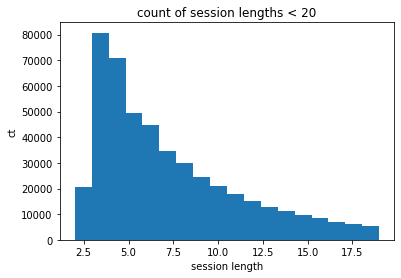

dataset len: 509696


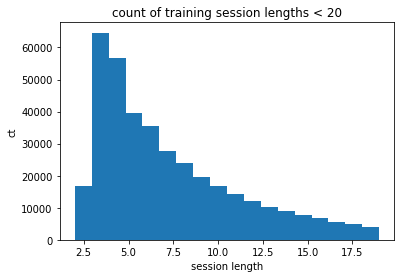

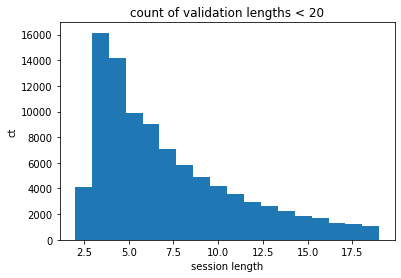

509696 examples
split into 407756 train, 101940 val, 0 test
[array([3647, 3647]), array([2329, 2329, 1047, 2329]), array([56, 56, 56]), array([ 250,  250, 6884]), array([  136, 36427, 36428, 36420,  7608,  7608,   288,   535]), array([46353, 46353, 12899, 11676]), array([46967, 46932, 46944, 45814, 22101, 12139, 46937, 47482, 47531, 46944, 47482, 47531]), array([4788,  248,  248,  248]), array([  121, 43182,   121, 43182, 43182, 43182]), array([  802, 28344,   802, 28344]), array([45316,   201,   419, 45299,   201]), array([4514, 1137,  818, 3513, 3319, 3513, 3513, 3513]), array([ 5765, 49304, 49304,  3447, 49304, 49304]), array([30744, 30740, 30740]), array([9760, 8779, 8779, 5862, 9760, 5862, 5862, 8779]), array([37900, 37870, 37900, 37882, 36718, 37870, 37900]), array([44606, 44618, 44606, 44618]), array([32209, 32209, 39239,  1075,  1075, 30930, 39287, 39296,  3034, 30930, 39296, 32209,  1075,  3034]), array([45224,   916,    63, 45224,   916,    63]), array([4956, 1192, 1189, 4956

In [2]:
dataset, column_names, keymap = load_yoochoose_dataset(reinitialize=False)
num_sessions = len(dataset)

max_embedding_key = len(keymap)-1
max_session_len = max([len(i) for i in dataset])

print(f"max_embedding_key: {max_embedding_key}")
print(f"max_session_len: {max_session_len}")

plt.hist([len(session) for session in dataset if len(session) < 20], bins=18)
plt.xlabel("session length")
plt.ylabel("ct")
plt.title("count of session lengths < 20")
plt.show()

# dataset = dataset[:int(len(dataset)/4)]
print(f"dataset len: {len(dataset)}")

# removing click vs buy info
dataset = [np.array([item[0] for item in session]) for session in dataset]

# key_counts = Counter([tuple(i) for i in more_itertools.flatten(dataset)])
# key_count_frequencies = list(dict(key_counts).values())
# plt.hist(key_count_frequencies, bins=400, log=True)
# plt.xlabel("count of key")
# plt.ylabel("count of count of key")
# most_common = {k: v for k, v in key_counts.most_common(4)}
# plt.title(f"most keys occur once, keys {most_common} are most common")
# plt.show()

(x_train,), (x_val,), (x_test,) = train_val_test_split(dataset, train_perc=.8, val_perc=.2, test_perc=0)

plt.hist([len(session) for session in x_train if len(session) < 20], bins=18)
plt.xlabel("session length")
plt.ylabel("ct")
plt.title("count of training session lengths < 20")
plt.show()

plt.hist([len(session) for session in x_val if len(session) < 20], bins=18)
plt.xlabel("session length")
plt.ylabel("ct")
plt.title("count of validation lengths < 20")
plt.show()

print(f"{len(dataset)} examples")
print(f"split into {len(x_train)} train, {len(x_val)} val, {len(x_test)} test")

print(x_train[:200])
print(x_val[:200])

In [3]:
"""
model notes:

Embedding layer:
    lower dimensional embedding + dropout

attention:
    given a variable length vector A of fixed length vectors, construct a fixed length vector where each element is the output of a tanh * sigmoid. the sigmoid is a gate on the tanh that determines how important that vector is A. Importance is calculated from sigmoid of the dot product between the vector with the trainable importance vector
    thus, attention is fundamentally a fully connected layer gated with sigmoid based on how similar the input is at that vector to the trainable importance vector.
    attention masking: 
        there is still the problem that the output of attention has to be a fixed length vector. 
        to do this, the goal is to pad the attention vector with zeros
        to do this, pad the output of u_{it}^T u_w with -infs so that the output of the softmax would be 0 and that these values won't affect the final ah

clustering:
    a softmax function with a stronger max
    take the inputs to clustering, pass them through a fully connected with the size of the output being the number of clusters, and hard softmax it. the hard softmax values will be the cluster that the vector belongs in. 

final attention layer on the clusters:
    do a softmax on the cluster embedding dot a importance vector and a softmax on the embedding dot the same importance vector. use those softmaxes to compute a weighted sum of the cluster embedding with the importance vector.

loss: 
    nce loss
"""
""

''

In [61]:
class GrumbelSoftmaxActivation(tf.keras.layers.Layer):
    def __init__(self, temp):
        super(GrumbelSoftmaxActivation, self).__init__()
        self.temp = temp
        self.gumbel = distributions.Gumbel(0, 1)
    
#     def build(self, input_shape):
    def call(self, values):
        values = tf.nn.softmax(values, axis=1)
        softmax_input = (tf.math.log(values)+self.gumbel.sample(values.shape))/self.temp
        output = tf.nn.softmax(softmax_input, axis=1)
        return output

class LocalAttention(tf.keras.layers.Layer):
    
    def __init__(self, max_session_len, embedding_size):
        super(LocalAttention, self).__init__()

        print("max_session_len", max_session_len, "embedding_size", embedding_size)
        self.max_session_len = max_session_len
        self.embedding_size = embedding_size
    
    # def build(self, input_shape):
        self.tanh_layer = Dense(
            self.embedding_size,
            activation='tanh',
            kernel_initializer='glorot_uniform',
            name="tanh_layer")
            # hidden layer = tanh(Wx + b)
            # hidden layer dim: [num_outputs, max_session_len, embedding_size]
        
        u_shape = [self.embedding_size]
        self.u = self.add_weight("importance", shape=u_shape)

    def call(self, values, mask):
        batch_size, cur_session_len, item_shape = values.shape[0],values.shape[1],values.shape[2:]
        item_dims = len(item_shape)
        # print("values", values)
        # values shape = [batch_size, cur_sess_len]+item_shape

        # mask shape = [batch_size, cur_sess_len]

        tanh_layer = self.tanh_layer(values)
        # print("tanh_layer", tanh_layer)
        # tanh shape = [batch_size, cur_sess_len, embedding_size]

        similarity_vector = tf.tensordot(tanh_layer, self.u, axes=([2], [0]))
        
        similarity_vector = similarity_vector+mask
        # similarity_vector shape = [batch_size, cur_sess_len]
        # print("similarity_vector", similarity_vector)

        # padding out the similarity_vector with -infinity values
        # padded_sim = tf.fill(dims=[self.max_session_len], value=-np.inf)
        # this_session_len = values.shape[0]
        # padded_sim[:this_session_len] = similarity_vector
        # padded_sim shape = max_session_len
#         tf.print("similarity vector", similarity_vector)

        weights = tf.nn.softmax(similarity_vector, axis=1)
        # weights shape = [batch_size, cur_session_len]
#         tf.print("weights", weights)
        # print("weights", weights)
    
        values_transpose_axes = [i+2 for i in range(item_dims)]+[0, 1]
        inv_values_transpose_axes = [item_dims, item_dims+1]+[i for i in range(item_dims)]
        weighted_inputs = tf.transpose(
            tf.transpose(values, perm=values_transpose_axes)*weights,
            perm=inv_values_transpose_axes
        )
        # weighted_inputs shape = [batch_size, cur_session_len]+item_shape
        # print("weighted_inputs", weighted_inputs)

        output = tf.math.reduce_sum(weighted_inputs, axis=1)
        # outputs shape = [batch_size, item_shape]
        # print("output", output)

        # output_pad_shape = [batch_size, self.max_session_len-cur_session_len]+item_shape
        # print("output_pad_shape", output_pad_shape)
        # output_pad = tf.zeros(output_pad_shape, dtype=tf.float32)

        # padded_output = tf.concat((output, output_pad), axis=2)

        # attention_weights shape == (batch_size, max_length, 1)
        # attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        # context_vector = attention_weights * values
        # context_vector = tf.reduce_sum(context_vector, axis=1)
        return output

class TestModel(Model):
    def __init__(self, max_embedding_key, max_session_len, embedding_size, gru_size, dense2_size, dense3_size, softmax_classes, temp):
        super(TestModel, self).__init__()
        self.max_embedding_key = max_embedding_key
        embedding_mtx_shape = [max_embedding_key, embedding_size]
        self.word_embedding_mtx = self.add_weight(
            initializer=tf.random_uniform_initializer(minval=-1, maxval=1), 
            shape=embedding_mtx_shape,
        )
        self.rnn = Bidirectional(GRU(gru_size, return_sequences=True), merge_mode="concat")
        self.attention1 = LocalAttention(max_session_len, gru_size)
        self.dense2 = Dense(
            dense2_size, 
            activation="linear", 
            kernel_initializer='he_normal'
        )
        self.dense2_act=tf.keras.layers.LeakyReLU()
        
        
        self.clustering = Dense(
            softmax_classes,
            activation="linear", 
            kernel_initializer='GlorotNormal'
        )
        self.clustering_act=GrumbelSoftmaxActivation(temp)
        self.clustering_map = Dense(
            dense2_size, 
            activation="linear", 
            kernel_initializer='he_normal'
        )
        self.clustering_map_act=tf.keras.layers.LeakyReLU()
        

        self.dense3 = Dense(
            dense3_size, 
            activation="linear", 
            kernel_initializer='he_normal'
        )
        self.dense3_act=tf.keras.layers.LeakyReLU()
        self.logits = Dense(
            max_embedding_key,
            activation="linear",
            kernel_initializer='GlorotNormal'
        )

#         nce_w_shape = (max_embedding_key, dense3_size)
#         self.nce_w = self.add_weight(
#             initializer=keras.initializers.TruncatedNormal(stddev=1.0/(dense3_size**0.5)),
#             shape=nce_w_shape
#         )

#         nce_b_shape = (max_embedding_key,)
#         self.nce_b = self.add_weight(
#             initializer=keras.initializers.Zeros(),
#             shape=nce_b_shape
#         )

    def call(self, x, mask, training=False):
        word_embeddings = tf.nn.embedding_lookup(self.word_embedding_mtx, x)
        rnn_output = self.rnn(word_embeddings)
        
        if training:
            attention_output = Dropout(.5)(self.attention1(rnn_output, mask))
            dense2 = self.dense2_act(self.dense2(attention_output))
            
            
            clusters = self.clustering_act(self.clustering(dense2))
            clusterout = self.clustering_map_act(self.clustering_map(clusters))
            cluster_att = tf.concat((dense2, clusterout), axis=1)
            
            dense3 = Dropout(.5)(self.dense3_act(self.dense3(cluster_att)))

            logits = self.logits(dense3)
            
#             logits = tf.matmul(nce_inputs, tf.transpose(self.nce_w))
#             logits = tf.nn.bias_add(logits, self.nce_b)

#             tf.print("logits", dense3)
#             return tf.reduce_mean(tf.nn.nce_loss(

        else:
            attention_output = self.attention1(rnn_output, mask)
            dense2 = self.dense2_act(self.dense2(attention_output))
            
            clusters = self.clustering_act(self.clustering(dense2))
            clusterout = self.clustering_map_act(self.clustering_map(clusters))
            cluster_att = tf.concat((dense2, clusterout), axis=1)
            
            
            
            dense3 = self.dense3_act(self.dense3(cluster_att))
            logits = self.logits(dense3)
#             logits = tf.matmul(nce_inputs, tf.transpose(self.nce_w))
#             logits = tf.nn.bias_add(logits, self.nce_b)
            noise = tf.random.uniform(logits.shape, maxval=10e-6)
            logits = logits + noise # adding the randomness cause topk categorical acc shitty
        
        softmax = tf.nn.softmax(logits)
        return logits, softmax
        
    def get_loss(self, y_true, logits):
#         print(y_true.shape, y_pred.shape)
        ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, logits)

        l1_reg = sum([tf.reduce_sum(tf.math.abs(tf.reshape(weight, [-1]))) for weight in self.trainable_variables])        
        num_trainable_variables = np.sum([np.prod(var.shape) for var in self.trainable_variables])
        l1_reg /= num_trainable_variables
        l1_reg *= 10
        loss = ce_loss+l1_reg
        tf.print("ce loss:", ce_loss, "l1 reg:", l1_reg, "total loss:", loss)
        return loss
#         return tf.nn.nce_loss(
#             weights=self.nce_w,
#             biases=self.nce_b,
#             labels=tf.reshape(y_true, [-1, 1]),
#             inputs=nce_inputs,
#             num_sampled=32,
#             num_classes=self.max_embedding_key
#         )

In [102]:
batch_size = 1024
print("batch_size", batch_size)

# splitting up long sessions by sampling them. a long session length is one without batch_size examples.
# x_train = sample_long_sessions(x_train, train_batch_size)
# x_val = sample_long_sessions(x_val, val_batch_size)

# model.fit(x_train_p, y_train_p, batch_size=batch_size, epochs=4, validation_data=[x_val, y_val])

# row_id_to_idx = {k: v for v, k in enumerate(set(clicks_df["sessionId"])|set(buys_df["sessionId"]))}
# col_id_to_idx = {k: v for v, k in enumerate(set(clicks_df["itemId"])|set(buys_df["itemId"]))}

# matrix_shape = (len(row_id_to_idx), len(col_id_to_idx))

# row_indices = [row_id_to_idx[row_id] for row_id in clicks_df["sessionId"]]
# col_indices = [col_id_to_idx[col_id] for col_id in clicks_df["itemId"]]
# elements = np.ones(len(col_indices), dtype=np.int8)
# viewed_matrix = csr_matrix((elements, (row_indices, col_indices)), shape=matrix_shape)

# row_indices = [row_id_to_idx[row_id] for row_id in buys_df["sessionId"]]
# col_indices = [col_id_to_idx[col_id] for col_id in buys_df["itemId"]]
# elements = np.ones(len(col_indices), dtype=np.int8)
# buys_matrix = csr_matrix((elements, (row_indices, col_indices)), shape=matrix_shape)

# interaction_matrix = 2*buys_matrix-viewed_matrix
model = TestModel(
    max_embedding_key=max_embedding_key, 
    max_session_len=max_session_len, 
    embedding_size=64,
    gru_size=64,
    dense2_size=256,
    dense3_size=128,
    softmax_classes=64,
    temp=.1
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

# train_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='train_loss')
train_accs = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=50),
]

# test_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_loss')
test_accs = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=50),
]

@tf.function
def train_step(sessions, mask, labels):
    with tf.GradientTape() as tape:
        logits, preds = model(sessions, mask, training=True)
        loss = model.get_loss(y_true=labels, logits=logits)
    gradients = tape.gradient(loss, model.trainable_variables)
#     print("median gradients", [(layer.name, np.median(grad.numpy())) for grad, layer in zip(gradients, model.trainable_variables)])
    gradients = [tf.clip_by_value(grad, -1., 1.) for grad in gradients] # clip grads to stop nan problem
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    for train_acc in train_accs:
        train_acc.update_state(labels, tf.cast(preds, tf.float32))

    return preds, loss

@tf.function
def test_step(sessions, mask, labels):
    logits, preds = model(sessions, mask, training=False)
#     t_loss = loss_object(labels, predictions)
    # test_loss(t_loss)
    for test_acc in test_accs:
        test_acc.update_state(labels, tf.cast(preds, tf.float32))

EPOCHS = 10
num_x = len(x_train)

train_accs_rec = defaultdict(lambda: [])
test_accs_rec = defaultdict(lambda: [])
train_losses_rec = []

for epoch in tqdm(list(range(EPOCHS))):
    print(f"epoch {epoch}/{EPOCHS}")
    # Reset the metrics at the start of the next epoch
    for train_acc in train_accs:
        train_acc.reset_states()
    for test_acc in test_accs:
        test_acc.reset_states()

    for i, [batch_sess] in tqdm(list(enumerate(batchify(x_train, shuffle=True, batch_size=batch_size)))):
        batch_labels = [sess[-1] for sess in batch_sess]
        batch_sess = [sess[:-1] for sess in batch_sess]

        batch_sess, mask = mask_length(batch_sess, maskon_vals=0, maskoff_vals=-np.inf)
#         print("batch_sess", batch_sess)
#         print("mask", mask)
#         print("labels", batch_labels)
#         print("test")
#         print("train")
        predictions, loss = train_step(tf.constant(batch_sess), tf.constant(mask), tf.constant(batch_labels))
        train_losses_rec.append(loss.numpy())
#         for _ in range(400):
#             predictions = train_step(tf.constant(batch_sess), tf.constant(mask), tf.constant(batch_labels))
#             test_step(tf.constant(batch_sess), tf.constant(mask), tf.constant(batch_labels))
#             print(f"train acc: {train_accs[0].result()} top5 train {train_accs[1].result()} top10 train {train_accs[2].result()} top20 train {train_accs[3].result()} top50 train {train_accs[4].result()}")
#             print(f"test acc: {test_accs[0].result()} top5 test {test_accs[1].result()} top10 test {test_accs[2].result()} top20 test {test_accs[3].result()} top50 test {test_accs[4].result()}")

        # print(model.variables)
#             tf.print(f"batch {i}/~{int(num_x/batch_size)} train acc: {top1_train_acc.result()} top10acc: {top10_train_acc.result()} session length: {len(batch_sess[0])}")

#                 print("labels", batch_labels)
#                 print("preds", tf.argmax(predictions, axis=1).numpy())
#             counted_preds = Counter(tf.argmax(predictions, axis=1).numpy())
#             if len(counted_preds) == 1:
#                 print(f"MODEL ONLY PREDICTING {list(counted_preds)[0]}")
#             else:
#                 print(f"predictions: {counted_preds}")
#             top1_train_acc.reset_states()
#             top10_train_acc.reset_states()

    for i, [batch_sess] in enumerate(batchify(x_val, shuffle=True, batch_size=batch_size)):
        # batch_sess, batch_labels = augment_negative_examples(batch_sess, max_embedding_key)
        batch_labels = [sess[-1] for sess in batch_sess]
        batch_sess = [sess[:-1] for sess in batch_sess]
        batch_sess, mask = mask_length(batch_sess, maskon_vals=0, maskoff_vals=-np.inf)
        test_step(tf.constant(batch_sess), tf.constant(mask), tf.constant(batch_labels))

    topn_labels = ["acc", "top5 acc", "top10 acc", "top20 acc", "top50 acc"]
    for label, train_acc, test_acc in zip(topn_labels, train_accs, test_accs):
        train_accs_rec[label].append(train_acc.result())
        test_accs_rec[label].append(test_acc.result())
        print(f"{label} train: {train_acc.result()}")
        print(f"{label} test: {test_acc.result()}")
    
    print(f"Epoch {epoch+1}")

batch_size 1024
max_session_len 262 embedding_size 64


epoch 0/10


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.8738766 l1 reg 1.67427516 total loss 12.548152


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.8688602 l1 reg 1.67270327 total loss 12.541563


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.8616734 l1 reg 1.67096543 total loss 12.5326385


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.8544579 l1 reg 1.66925955 total loss 12.5237179


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.8403435 l1 reg 1.66769516 total loss 12.5080385


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.8239288 l1 reg 1.66635442 total loss 12.490283


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.8021698 l1 reg 1.66530406 total loss 12.467474


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.7809734 l1 reg 1.66460145 total loss 12.4455748


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.7433186 l1 reg 1.6642921 total loss 12.4076109


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.679533 l1 reg 1.66440451 total loss 12.3439379
ce loss 10.6442986 l1 reg 1.66497064 total loss 12.309269


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.5321083 l1 reg 1.66600513 total loss 12.1981134
ce loss 10.3953485 l1 reg 1.66751456 total loss 12.0628633


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 10.2369041 l1 reg 1.66948926 total loss 11.9063931
ce loss 10.017252 l1 reg 1.67191052 total loss 11.6891623
ce loss 9.8048 l1 reg 1.67475295 total loss 11.4795532
ce loss 9.51776314 l1 reg 1.67799044 total loss 11.1957531
ce loss 9.09813404 l1 reg 1.68158889 total loss 10.7797232
ce loss 8.72760391 l1 reg 1.68548882 total loss 10.4130926


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.6961441 l1 reg 1.68959475 total loss 10.3857384


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.83100414 l1 reg 1.6937201 total loss 10.524724
ce loss 8.94677067 l1 reg 1.69764 total loss 10.6444111


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 9.02348232 l1 reg 1.70122981 total loss 10.7247124


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.78445053 l1 reg 1.7044369 total loss 10.4888878


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.74450302 l1 reg 1.70729685 total loss 10.4517994
ce loss 8.58183765 l1 reg 1.70986295 total loss 10.2917
ce loss 8.6419611 l1 reg 1.71218264 total loss 10.3541441
ce loss 8.54346561 l1 reg 1.7143141 total loss 10.2577801
ce loss 8.57333755 l1 reg 1.71633708 total loss 10.2896748
ce loss 8.43682289 l1 reg 1.71832561 total loss 10.1551485
ce loss 8.54600048 l1 reg 1.72029173 total loss 10.2662926
ce loss 8.38583088 l1 reg 1.7222867 total loss 10.1081181
ce loss 8.55066 l1 reg 1.72431219 total loss 10.274972
ce loss 8.40975952 l1 reg 1.72637606 total loss 10.1361351


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.5266552 l1 reg 1.72846 total loss 10.2551155
ce loss 8.51702 l1 reg 1.73056638 total loss 10.2475863
ce loss 8.37239838 l1 reg 1.73267221 total loss 10.1050701
ce loss 8.45276833 l1 reg 1.73473859 total loss 10.1875067
ce loss 8.40881 l1 reg 1.73673487 total loss 10.1455441
ce loss 8.40254211 l1 reg 1.73863661 total loss 10.1411791


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.32128 l1 reg 1.74040461 total loss 10.0616837
ce loss 8.37575245 l1 reg 1.74203038 total loss 10.1177826
ce loss 8.3706255 l1 reg 1.74349177 total loss 10.1141176
ce loss 8.52173901 l1 reg 1.74478614 total loss 10.2665253


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.38872528 l1 reg 1.74591339 total loss 10.1346388
ce loss 8.38462925 l1 reg 1.74687707 total loss 10.131506
ce loss 8.36500168 l1 reg 1.74769545 total loss 10.1126976
ce loss 8.45371914 l1 reg 1.74837852 total loss 10.2020979


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.3187685 l1 reg 1.74893522 total loss 10.0677032
ce loss 8.29003239 l1 reg 1.74939096 total loss 10.039423
ce loss 8.2997427 l1 reg 1.74976408 total loss 10.0495071
ce loss 8.29072475 l1 reg 1.75007749 total loss 10.040802
ce loss 8.19203091 l1 reg 1.75035214 total loss 9.94238281
ce loss 8.37043285 l1 reg 1.7506175 total loss 10.1210499
ce loss 8.20584393 l1 reg 1.75089312 total loss 9.95673752


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.30018234 l1 reg 1.75116241 total loss 10.0513449


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.16146946 l1 reg 1.75143516 total loss 9.91290474
ce loss 8.24537849 l1 reg 1.75170624 total loss 9.99708462
ce loss 8.16339779 l1 reg 1.75196135 total loss 9.9153595
ce loss 8.31666374 l1 reg 1.75218678 total loss 10.0688505
ce loss 8.22865486 l1 reg 1.75236845 total loss 9.98102379
ce loss 8.19169617 l1 reg 1.75250113 total loss 9.94419765
ce loss 8.26229095 l1 reg 1.75258541 total loss 10.0148764
ce loss 8.11364079 l1 reg 1.75261915 total loss 9.86626
ce loss 8.10870266 l1 reg 1.75258744 total loss 9.86129
ce loss 8.11727 l1 reg 1.75249457 total loss 9.86976528
ce loss 8.28296661 l1 reg 1.7523315 total loss 10.0352983
ce loss 8.08427429 l1 reg 1.75211883 total loss 9.83639336
ce loss 8.09773445 l1 reg 1.7518568 total loss 9.84959126
ce loss 8.18842602 l1 reg 1.75157368 total loss 9.94
ce loss 8.07906532 l1 reg 1.75127316 total loss 9.83033848
ce loss 8.2393074 l1 reg 1.75096226 total loss 9.99027
ce loss 8.16110325 l1 reg 1.75065064 total loss 9.91175365
ce loss 8.12918 l1 

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 8.02329826 l1 reg 1.74113214 total loss 9.76443
ce loss 7.97697258 l1 reg 1.74062455 total loss 9.71759701
ce loss 7.88567352 l1 reg 1.74011993 total loss 9.62579346
ce loss 7.95793533 l1 reg 1.73960543 total loss 9.69754
ce loss 7.78386497 l1 reg 1.73908091 total loss 9.5229454
ce loss 7.92851257 l1 reg 1.73852921 total loss 9.66704178
ce loss 7.92547178 l1 reg 1.73794711 total loss 9.66341877
ce loss 7.99891567 l1 reg 1.73733938 total loss 9.73625469
ce loss 7.87479305 l1 reg 1.73669529 total loss 9.61148834
ce loss 7.89446354 l1 reg 1.73602557 total loss 9.63048935
ce loss 7.77091074 l1 reg 1.73534131 total loss 9.50625229
ce loss 7.79637575 l1 reg 1.73464942 total loss 9.53102493
ce loss 7.92589378 l1 reg 1.73396909 total loss 9.65986252
ce loss 7.87362814 l1 reg 1.73329806 total loss 9.60692596
ce loss 7.79838085 l1 reg 1.7326529 total loss 9.53103352
ce loss 7.74463749 l1 reg 1.73202097 total loss 9.47665882
ce loss 7.85447025 l1 reg 1.73138678 total loss 9.58585739
ce lo

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 7.63726568 l1 reg 1.71998048 total loss 9.3572464
ce loss 7.6480093 l1 reg 1.71911705 total loss 9.36712646


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 7.58609533 l1 reg 1.71825802 total loss 9.30435371
ce loss 7.60765839 l1 reg 1.71740806 total loss 9.32506657
ce loss 7.7175827 l1 reg 1.71657073 total loss 9.43415356
ce loss 7.79609394 l1 reg 1.7157495 total loss 9.51184368
ce loss 7.50270796 l1 reg 1.7149421 total loss 9.21765
ce loss 7.65953636 l1 reg 1.71414137 total loss 9.37367821
ce loss 7.57525158 l1 reg 1.71335781 total loss 9.2886095
ce loss 7.47618103 l1 reg 1.71257567 total loss 9.18875694
ce loss 7.44670582 l1 reg 1.71179533 total loss 9.15850067


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 7.49089336 l1 reg 1.71100485 total loss 9.20189857


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 7.50879145 l1 reg 1.71020901 total loss 9.21900082


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 7.6260891 l1 reg 1.7093935 total loss 9.3354826
ce loss 7.55964708 l1 reg 1.708565 total loss 9.26821232
ce loss 7.51521683 l1 reg 1.70772123 total loss 9.22293854
ce loss 7.54973459 l1 reg 1.70686257 total loss 9.25659752
ce loss 7.505 l1 reg 1.70600474 total loss 9.21100521
ce loss 7.40628529 l1 reg 1.70513129 total loss 9.11141682
ce loss 7.44702148 l1 reg 1.70425344 total loss 9.15127468
ce loss 7.36729813 l1 reg 1.70337653 total loss 9.0706749
ce loss 7.44468117 l1 reg 1.70248592 total loss 9.14716721
ce loss 7.53542376 l1 reg 1.70158291 total loss 9.23700714
ce loss 7.30847168 l1 reg 1.70066202 total loss 9.00913334
ce loss 7.4470129 l1 reg 1.6997267 total loss 9.14674
ce loss 7.34345913 l1 reg 1.69878328 total loss 9.04224205
ce loss 7.32162476 l1 reg 1.69783258 total loss 9.01945686
ce loss 7.20212364 l1 reg 1.69687331 total loss 8.89899731
ce loss 7.58425045 l1 reg 1.69589388 total loss 9.28014469
ce loss 7.07997894 l1 reg 1.69489062 total loss 8.77487
ce loss 7.272239

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 7.10995579 l1 reg 1.67805386 total loss 8.78801
ce loss 7.29324102 l1 reg 1.67694986 total loss 8.970191
ce loss 7.04072762 l1 reg 1.67584944 total loss 8.71657753
ce loss 7.26459599 l1 reg 1.67474782 total loss 8.93934345
ce loss 7.05725288 l1 reg 1.67364252 total loss 8.73089504
ce loss 7.30672598 l1 reg 1.67253053 total loss 8.97925663
ce loss 6.95405579 l1 reg 1.67142367 total loss 8.62548
ce loss 7.06305552 l1 reg 1.67030942 total loss 8.73336506
ce loss 7.0516181 l1 reg 1.66918683 total loss 8.72080517
ce loss 7.16538525 l1 reg 1.66804087 total loss 8.83342648
ce loss 7.12373638 l1 reg 1.66688621 total loss 8.79062271
ce loss 7.09337234 l1 reg 1.66573215 total loss 8.75910473
ce loss 6.9224 l1 reg 1.66457379 total loss 8.58697414
ce loss 6.85412693 l1 reg 1.66341031 total loss 8.51753712
ce loss 7.00543642 l1 reg 1.66222632 total loss 8.66766262
ce loss 7.02133036 l1 reg 1.66103613 total loss 8.68236637
ce loss 6.8172121 l1 reg 1.65984082 total loss 8.47705269
ce loss 7.0

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 6.58366299 l1 reg 1.6195029 total loss 8.20316601


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 6.67492 l1 reg 1.6182363 total loss 8.29315662
ce loss 6.80914545 l1 reg 1.61696291 total loss 8.42610836
ce loss 6.54939461 l1 reg 1.61571383 total loss 8.16510868
ce loss 6.63948774 l1 reg 1.61447513 total loss 8.25396252
ce loss 6.51792049 l1 reg 1.61323416 total loss 8.13115501
ce loss 6.61258602 l1 reg 1.61198556 total loss 8.22457123


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 6.71488571 l1 reg 1.6107353 total loss 8.32562065
ce loss 6.51965714 l1 reg 1.60948408 total loss 8.12914085
ce loss 6.55377293 l1 reg 1.60821712 total loss 8.16199
ce loss 6.5511322 l1 reg 1.60695088 total loss 8.15808296
ce loss 6.68109417 l1 reg 1.60566664 total loss 8.28676
ce loss 6.60143 l1 reg 1.60436785 total loss 8.20579815
ce loss 6.51207161 l1 reg 1.60305536 total loss 8.11512661
ce loss 6.36814976 l1 reg 1.6017431 total loss 7.96989298
ce loss 6.50422 l1 reg 1.60041237 total loss 8.10463238
ce loss 6.58998251 l1 reg 1.59908378 total loss 8.18906593
ce loss 6.61158657 l1 reg 1.5977546 total loss 8.20934105


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 6.47876263 l1 reg 1.59642386 total loss 8.07518673
ce loss 6.31690788 l1 reg 1.59510887 total loss 7.91201687
ce loss 6.4450593 l1 reg 1.59379685 total loss 8.03885651
ce loss 6.41485 l1 reg 1.59248543 total loss 8.00733566
ce loss 6.40426922 l1 reg 1.59117186 total loss 7.99544096
ce loss 6.26552057 l1 reg 1.589854 total loss 7.85537434
ce loss 6.38958883 l1 reg 1.58850193 total loss 7.97809076
ce loss 6.16755772 l1 reg 1.58712351 total loss 7.75468111
ce loss 6.50292969 l1 reg 1.58572257 total loss 8.08865261
ce loss 6.47960138 l1 reg 1.5843035 total loss 8.06390476
ce loss 6.4774847 l1 reg 1.58286023 total loss 8.0603447
ce loss 6.24227858 l1 reg 1.58139884 total loss 7.82367754


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 6.43825388 l1 reg 1.57991946 total loss 8.01817322
ce loss 6.26815319 l1 reg 1.57843184 total loss 7.84658527
ce loss 6.31618261 l1 reg 1.57693648 total loss 7.89311886
ce loss 6.41171646 l1 reg 1.5754385 total loss 7.98715496
ce loss 6.31503439 l1 reg 1.57393193 total loss 7.88896656
ce loss 6.13255882 l1 reg 1.57241154 total loss 7.70497036
ce loss 6.31905174 l1 reg 1.57087445 total loss 7.88992596
ce loss 6.26656437 l1 reg 1.56934941 total loss 7.83591366
ce loss 6.22279 l1 reg 1.56784022 total loss 7.79063
ce loss 6.34675503 l1 reg 1.56633008 total loss 7.91308498
ce loss 6.25384569 l1 reg 1.56484032 total loss 7.81868601
ce loss 6.2393117 l1 reg 1.56336093 total loss 7.80267239
ce loss 6.06468105 l1 reg 1.56189358 total loss 7.62657452
ce loss 6.28183651 l1 reg 1.56043446 total loss 7.84227085
ce loss 5.95394325 l1 reg 1.55897903 total loss 7.51292229
ce loss 6.04703045 l1 reg 1.55752337 total loss 7.6045537
ce loss 6.29658031 l1 reg 1.55604315 total loss 7.85262346
ce los

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 6.27558899 l1 reg 1.5335604 total loss 7.80914927
ce loss 5.97600508 l1 reg 1.53215587 total loss 7.50816107
ce loss 6.38259029 l1 reg 1.53075361 total loss 7.91334391
ce loss 6.04064751 l1 reg 1.52934992 total loss 7.56999731
ce loss 6.01731491 l1 reg 1.52792811 total loss 7.54524326
ce loss 6.02564573 l1 reg 1.52650595 total loss 7.55215168
ce loss 6.15150118 l1 reg 1.52509952 total loss 7.67660046
ce loss 6.02369642 l1 reg 1.52368605 total loss 7.54738235
ce loss 6.18694258 l1 reg 1.52225482 total loss 7.70919752
ce loss 6.15566492 l1 reg 1.52081263 total loss 7.67647743
ce loss 6.08816099 l1 reg 1.51937115 total loss 7.60753202
ce loss 6.10715723 l1 reg 1.51792729 total loss 7.6250844
ce loss 6.03490496 l1 reg 1.51647615 total loss 7.55138111
ce loss 6.13946629 l1 reg 1.51501024 total loss 7.65447664
ce loss 6.02458954 l1 reg 1.51355124 total loss 7.53814077
ce loss 5.99644852 l1 reg 1.51207244 total loss 7.50852108
ce loss 6.10962677 l1 reg 1.51059103 total loss 7.6202178


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 6.06791449 l1 reg 1.50612628 total loss 7.57404089
ce loss 5.81175 l1 reg 1.50463402 total loss 7.31638384
ce loss 6.01780558 l1 reg 1.50313103 total loss 7.52093649
ce loss 5.91778708 l1 reg 1.50163543 total loss 7.41942263
ce loss 6.0660615 l1 reg 1.50015 total loss 7.5662117
ce loss 6.07478189 l1 reg 1.49867463 total loss 7.57345676
ce loss 6.10039234 l1 reg 1.49717927 total loss 7.59757137
ce loss 6.01485348 l1 reg 1.49567676 total loss 7.51053047
ce loss 5.73497677 l1 reg 1.49416256 total loss 7.22913933
ce loss 5.92966318 l1 reg 1.49264073 total loss 7.42230415
ce loss 5.95217085 l1 reg 1.49110937 total loss 7.44328
ce loss 6.06848812 l1 reg 1.48955595 total loss 7.55804396
ce loss 5.90758514 l1 reg 1.48798954 total loss 7.39557457
ce loss 5.76359415 l1 reg 1.48642468 total loss 7.25001907


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 5.76366138 l1 reg 1.48483896 total loss 7.24850035
ce loss 5.68901491 l1 reg 1.48324823 total loss 7.17226315
ce loss 5.98697329 l1 reg 1.4816556 total loss 7.46862888
ce loss 5.91992664 l1 reg 1.48006666 total loss 7.39999342
ce loss 5.75651503 l1 reg 1.47847474 total loss 7.23498964
ce loss 5.98550129 l1 reg 1.47687411 total loss 7.46237564
ce loss 5.96500874 l1 reg 1.47526956 total loss 7.44027805
ce loss 5.71596575 l1 reg 1.47365189 total loss 7.18961763
ce loss 5.86086941 l1 reg 1.47203565 total loss 7.33290482
ce loss 5.88357925 l1 reg 1.47040343 total loss 7.35398293
ce loss 5.67528772 l1 reg 1.46875536 total loss 7.14404297
ce loss 5.803895 l1 reg 1.46710622 total loss 7.27100134
ce loss 5.64342356 l1 reg 1.46545279 total loss 7.10887623
ce loss 5.8196063 l1 reg 1.46379101 total loss 7.2833972
ce loss 5.87646294 l1 reg 1.46211731 total loss 7.33858
ce loss 5.95927143 l1 reg 1.46045244 total loss 7.41972399


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 5.79730225 l1 reg 1.4588052 total loss 7.25610733
ce loss 5.76821756 l1 reg 1.45715201 total loss 7.22536945
ce loss 5.75372505 l1 reg 1.45550299 total loss 7.20922804
ce loss 5.86304235 l1 reg 1.45385444 total loss 7.31689692
ce loss 5.87614584 l1 reg 1.45220041 total loss 7.32834625
ce loss 5.92408752 l1 reg 1.4505502 total loss 7.3746376
ce loss 6.09825277 l1 reg 1.44891596 total loss 7.54716873
ce loss 5.7419076 l1 reg 1.44729209 total loss 7.18919945
ce loss 5.84382582 l1 reg 1.4456749 total loss 7.28950071
ce loss 5.73579121 l1 reg 1.44406879 total loss 7.17986
ce loss 5.72541094 l1 reg 1.44246292 total loss 7.16787386
ce loss 5.76473284 l1 reg 1.44086909 total loss 7.20560169
ce loss 5.80277157 l1 reg 1.43928695 total loss 7.24205875
ce loss 5.61705112 l1 reg 1.43770671 total loss 7.05475807
ce loss 5.64692211 l1 reg 1.43611622 total loss 7.08303833
ce loss 5.59789276 l1 reg 1.43451405 total loss 7.03240681
ce loss 5.62897253 l1 reg 1.43289614 total loss 7.06186867
ce lo

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 5.09026146 l1 reg 1.3401854 total loss 6.43044662



acc train: 0.1369152069091797
acc test: 0.3430841565132141
top5 acc train: 0.22872501611709595
top5 acc test: 0.5062879920005798
top10 acc train: 0.26912662386894226
top10 acc test: 0.554365336894989
top20 acc train: 0.3114534318447113
top20 acc test: 0.5965960621833801
top50 acc train: 0.3774585723876953
top50 acc test: 0.6516970992088318
Epoch 1
epoch 1/10


ce loss 5.59827042 l1 reg 1.33860314 total loss 6.93687344
ce loss 5.34731579 l1 reg 1.3370415 total loss 6.68435717
ce loss 5.48643684 l1 reg 1.33548105 total loss 6.82191801
ce loss 5.27567148 l1 reg 1.33391428 total loss 6.60958576
ce loss 5.22859812 l1 reg 1.33233869 total loss 6.56093693
ce loss 5.58870125 l1 reg 1.33074892 total loss 6.91945028
ce loss 5.38632107 l1 reg 1.32913983 total loss 6.71546078
ce loss 5.51693153 l1 reg 1.32751858 total loss 6.84445
ce loss 5.28701067 l1 reg 1.32587945 total loss 6.61289024
ce loss 5.22002888 l1 reg 1.3242172 total loss 6.5442462
ce loss 5.29852867 l1 reg 1.32253969 total loss 6.62106848
ce loss 5.15359879 l1 reg 1.32085228 total loss 6.47445107
ce loss 5.44339 l1 reg 1.31914914 total loss 6.76253891
ce loss 5.13290119 l1 reg 1.31742644 total loss 6.45032787
ce loss 5.30805874 l1 reg 1.31569946 total loss 6.62375832
ce loss 5.40460968 l1 reg 1.31396568 total loss 6.71857548
ce loss 5.26010132 l1 reg 1.31223214 total loss 6.57233334
ce los

ce loss 5.11700153 l1 reg 1.12343323 total loss 6.24043465
ce loss 4.80656672 l1 reg 1.12211359 total loss 5.92868042
ce loss 4.87271881 l1 reg 1.12081146 total loss 5.99353027
ce loss 4.88593674 l1 reg 1.11950815 total loss 6.005445
ce loss 5.12054205 l1 reg 1.11820412 total loss 6.23874617
ce loss 4.95598412 l1 reg 1.11690795 total loss 6.07289219
ce loss 5.20605898 l1 reg 1.11562836 total loss 6.32168722
ce loss 5.34939432 l1 reg 1.11436272 total loss 6.46375704
ce loss 4.97204256 l1 reg 1.1131041 total loss 6.0851469
ce loss 4.88407183 l1 reg 1.11184645 total loss 5.99591827
ce loss 4.68805075 l1 reg 1.11058009 total loss 5.79863071
ce loss 5.02058697 l1 reg 1.1092906 total loss 6.12987757
ce loss 4.99635267 l1 reg 1.10800076 total loss 6.10435343
ce loss 5.05088 l1 reg 1.10671484 total loss 6.15759468
ce loss 4.90137482 l1 reg 1.10541892 total loss 6.00679398
ce loss 4.95350885 l1 reg 1.10411978 total loss 6.05762863
ce loss 4.94803667 l1 reg 1.10282028 total loss 6.05085707
ce lo

ce loss 4.71991444 l1 reg 0.965367258 total loss 5.68528175
ce loss 4.72087812 l1 reg 0.964438677 total loss 5.68531704
ce loss 4.72211504 l1 reg 0.963511944 total loss 5.68562698
ce loss 4.88523 l1 reg 0.96259886 total loss 5.84782887
ce loss 4.78608036 l1 reg 0.961694777 total loss 5.74777508
ce loss 4.64028931 l1 reg 0.960791886 total loss 5.60108137
ce loss 4.73356724 l1 reg 0.959889174 total loss 5.69345665
ce loss 4.72431469 l1 reg 0.958984137 total loss 5.68329906
ce loss 4.50487614 l1 reg 0.958073914 total loss 5.46295
ce loss 4.87336 l1 reg 0.957161248 total loss 5.83052158
ce loss 4.95006275 l1 reg 0.956239045 total loss 5.90630198
ce loss 4.64199924 l1 reg 0.955307841 total loss 5.59730721
ce loss 4.74014854 l1 reg 0.954377115 total loss 5.69452572
ce loss 4.76581049 l1 reg 0.953443646 total loss 5.71925402
ce loss 4.51673746 l1 reg 0.952507436 total loss 5.46924496
ce loss 4.68893814 l1 reg 0.951575 total loss 5.64051294
ce loss 5.00730419 l1 reg 0.950651884 total loss 5.95

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 4.93344498 l1 reg 0.867616415 total loss 5.80106163

acc train: 0.31940916180610657
acc test: 0.42189523577690125
top5 acc train: 0.48598426580429077
top5 acc test: 0.616195797920227
top10 acc train: 0.5416180491447449
top10 acc test: 0.6652638912200928
top20 acc train: 0.5912898778915405
top20 acc test: 0.7054345607757568
top50 acc train: 0.6536335349082947
top50 acc test: 0.7521287202835083
Epoch 2
epoch 2/10


ce loss 4.4653244 l1 reg 0.866923869 total loss 5.33224821
ce loss 4.49616861 l1 reg 0.866233945 total loss 5.36240244
ce loss 4.37431288 l1 reg 0.865530789 total loss 5.23984385
ce loss 4.4438467 l1 reg 0.864813387 total loss 5.30866
ce loss 4.29259968 l1 reg 0.864095926 total loss 5.15669537
ce loss 4.19308519 l1 reg 0.863379061 total loss 5.0564642
ce loss 4.2709 l1 reg 0.862660408 total loss 5.13356
ce loss 4.38897419 l1 reg 0.861941 total loss 5.25091505
ce loss 4.50452757 l1 reg 0.861219108 total loss 5.3657465
ce loss 4.30075884 l1 reg 0.860489309 total loss 5.16124821
ce loss 4.43893576 l1 reg 0.859749556 total loss 5.29868507
ce loss 4.40872 l1 reg 0.859014809 total loss 5.267735
ce loss 4.53614044 l1 reg 0.858277857 total loss 5.39441824
ce loss 4.28792286 l1 reg 0.857534289 total loss 5.14545727
ce loss 4.3489809 l1 reg 0.856780469 total loss 5.20576143
ce loss 4.24704456 l1 reg 0.856019378 total loss 5.10306406
ce loss 4.50232506 l1 reg 0.85525161 total loss 5.35757685
ce l

ce loss 4.35232496 l1 reg 0.777746856 total loss 5.13007164
ce loss 4.28395414 l1 reg 0.7772578 total loss 5.06121206
ce loss 4.55845547 l1 reg 0.776764214 total loss 5.33522
ce loss 4.13618898 l1 reg 0.776270688 total loss 4.91246
ce loss 4.31387281 l1 reg 0.775784969 total loss 5.08965778
ce loss 4.19689798 l1 reg 0.775300741 total loss 4.97219849
ce loss 4.19634247 l1 reg 0.774819732 total loss 4.97116232
ce loss 4.25597811 l1 reg 0.774343789 total loss 5.03032207
ce loss 3.9621954 l1 reg 0.773864031 total loss 4.73605919
ce loss 4.31901264 l1 reg 0.773371816 total loss 5.09238434
ce loss 4.19665194 l1 reg 0.77287966 total loss 4.96953154
ce loss 4.28107595 l1 reg 0.772386253 total loss 5.05346203
ce loss 4.39530039 l1 reg 0.771899164 total loss 5.16719961
ce loss 4.12483406 l1 reg 0.771419287 total loss 4.89625359
ce loss 4.34131479 l1 reg 0.770939291 total loss 5.11225414
ce loss 4.28598404 l1 reg 0.77046144 total loss 5.0564456
ce loss 4.41261864 l1 reg 0.769974709 total loss 5.1

ce loss 4.12983799 l1 reg 0.723432302 total loss 4.85327053
ce loss 4.2710371 l1 reg 0.723155677 total loss 4.9941926
ce loss 4.27262 l1 reg 0.722880363 total loss 4.99550056
ce loss 4.2493782 l1 reg 0.722595096 total loss 4.97197342
ce loss 4.6132288 l1 reg 0.722313821 total loss 5.33554268
ce loss 4.35575 l1 reg 0.722026825 total loss 5.07777691
ce loss 3.97431278 l1 reg 0.721741736 total loss 4.69605446
ce loss 4.41557407 l1 reg 0.721465647 total loss 5.13703966
ce loss 4.42249393 l1 reg 0.721193612 total loss 5.14368773
ce loss 4.07071781 l1 reg 0.720919549 total loss 4.79163742
ce loss 4.11225414 l1 reg 0.720647037 total loss 4.832901
ce loss 4.27115536 l1 reg 0.720369756 total loss 4.99152517
ce loss 4.41177702 l1 reg 0.720098734 total loss 5.13187599
ce loss 4.3592248 l1 reg 0.719833612 total loss 5.07905865
ce loss 4.06779766 l1 reg 0.71957 total loss 4.78736782
ce loss 4.26733923 l1 reg 0.719310641 total loss 4.98665
ce loss 4.03356361 l1 reg 0.719053864 total loss 4.75261736


/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 4.26970387 l1 reg 0.698199391 total loss 4.96790314

acc train: 0.37174928188323975
acc test: 0.4531096816062927
top5 acc train: 0.5552830696105957
top5 acc test: 0.6576613783836365
top10 acc train: 0.6130455732345581
top10 acc test: 0.7064449787139893
top20 acc train: 0.6625236868858337
top20 acc test: 0.7447223663330078
top50 acc train: 0.7221450805664062
top50 acc test: 0.7869530916213989
Epoch 3
epoch 3/10


ce loss 4.02325964 l1 reg 0.698050201 total loss 4.72130966
ce loss 4.00040436 l1 reg 0.697910845 total loss 4.69831514
ce loss 3.93573046 l1 reg 0.697770715 total loss 4.63350105
ce loss 3.92172337 l1 reg 0.697631419 total loss 4.61935472
ce loss 3.8663311 l1 reg 0.697498 total loss 4.56382895
ce loss 3.92421556 l1 reg 0.697374046 total loss 4.62158966
ce loss 3.93650532 l1 reg 0.697248459 total loss 4.63375378
ce loss 4.07612038 l1 reg 0.697125793 total loss 4.77324629
ce loss 3.99110532 l1 reg 0.697004378 total loss 4.68811
ce loss 3.89766312 l1 reg 0.696874082 total loss 4.59453726
ce loss 3.93362379 l1 reg 0.69674027 total loss 4.63036394
ce loss 3.85453486 l1 reg 0.696612895 total loss 4.55114794
ce loss 3.77364779 l1 reg 0.696483552 total loss 4.4701314
ce loss 3.91143608 l1 reg 0.696341515 total loss 4.6077776
ce loss 3.88467932 l1 reg 0.696188509 total loss 4.58086777
ce loss 4.08145857 l1 reg 0.696038783 total loss 4.77749729
ce loss 4.03176785 l1 reg 0.695882857 total loss 4

ce loss 3.94781399 l1 reg 0.677513242 total loss 4.62532711
ce loss 4.05123949 l1 reg 0.677399218 total loss 4.72863865
ce loss 4.01259756 l1 reg 0.677289069 total loss 4.68988657
ce loss 3.69767666 l1 reg 0.677186191 total loss 4.37486267
ce loss 3.75755095 l1 reg 0.677091181 total loss 4.43464231
ce loss 3.81230521 l1 reg 0.676995456 total loss 4.48930073
ce loss 3.7486496 l1 reg 0.676900089 total loss 4.42554951
ce loss 3.66735339 l1 reg 0.676799476 total loss 4.34415293
ce loss 3.90536499 l1 reg 0.676696777 total loss 4.58206177
ce loss 3.93455 l1 reg 0.676593244 total loss 4.61114311
ce loss 3.73836756 l1 reg 0.676487923 total loss 4.41485548
ce loss 3.89230919 l1 reg 0.676381588 total loss 4.56869078
ce loss 3.82891655 l1 reg 0.676284909 total loss 4.50520134
ce loss 3.87885332 l1 reg 0.676184714 total loss 4.55503798
ce loss 3.96556449 l1 reg 0.67607379 total loss 4.64163828
ce loss 3.88396072 l1 reg 0.675959527 total loss 4.55992031
ce loss 3.81714964 l1 reg 0.675851882 total l

ce loss 3.96808839 l1 reg 0.664101183 total loss 4.63218975
ce loss 4.05055571 l1 reg 0.664023161 total loss 4.71457863
ce loss 3.82019615 l1 reg 0.663942099 total loss 4.48413849
ce loss 4.09586 l1 reg 0.663856566 total loss 4.75971651
ce loss 4.03716755 l1 reg 0.663769126 total loss 4.70093679
ce loss 4.01591206 l1 reg 0.663682818 total loss 4.67959499
ce loss 3.67316723 l1 reg 0.663607 total loss 4.33677435
ce loss 3.92809844 l1 reg 0.663529694 total loss 4.59162807
ce loss 3.90537786 l1 reg 0.663460076 total loss 4.56883812
ce loss 4.00539589 l1 reg 0.66339612 total loss 4.66879177
ce loss 3.83771801 l1 reg 0.663320839 total loss 4.50103903
ce loss 4.11809444 l1 reg 0.663246155 total loss 4.7813406
ce loss 3.87581849 l1 reg 0.663166523 total loss 4.53898525
ce loss 3.80918241 l1 reg 0.663088679 total loss 4.47227097
ce loss 3.93288875 l1 reg 0.663013399 total loss 4.59590197
ce loss 4.16253614 l1 reg 0.662934482 total loss 4.82547045
ce loss 3.97695971 l1 reg 0.662847579 total loss

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 3.69933486 l1 reg 0.655027926 total loss 4.35436296

acc train: 0.4040210247039795
acc test: 0.47948792576789856
top5 acc train: 0.5940734148025513
top5 acc test: 0.6818030476570129
top10 acc train: 0.6521301865577698
top10 acc test: 0.7300176620483398
top20 acc train: 0.7002055048942566
top20 acc test: 0.7672454118728638
top50 acc train: 0.7571415305137634
top50 acc test: 0.8065823316574097
Epoch 4
epoch 4/10


ce loss 3.57725 l1 reg 0.654957235 total loss 4.2322073
ce loss 3.70950127 l1 reg 0.654899955 total loss 4.36440134
ce loss 3.55102921 l1 reg 0.654833734 total loss 4.205863
ce loss 3.53207207 l1 reg 0.654761076 total loss 4.18683338
ce loss 3.80214739 l1 reg 0.654679835 total loss 4.45682716
ce loss 3.5159564 l1 reg 0.654601395 total loss 4.17055798
ce loss 3.5737462 l1 reg 0.654526651 total loss 4.22827291
ce loss 3.62461662 l1 reg 0.654457688 total loss 4.27907419
ce loss 3.46770477 l1 reg 0.654379189 total loss 4.12208414
ce loss 3.62031031 l1 reg 0.654295862 total loss 4.27460623
ce loss 3.55853558 l1 reg 0.654207945 total loss 4.21274376
ce loss 3.91851377 l1 reg 0.654121041 total loss 4.5726347
ce loss 3.44323421 l1 reg 0.654035866 total loss 4.09727
ce loss 3.65025687 l1 reg 0.653955102 total loss 4.30421209
ce loss 3.60543346 l1 reg 0.653875053 total loss 4.25930834
ce loss 3.61357284 l1 reg 0.653790653 total loss 4.26736355
ce loss 3.62273932 l1 reg 0.653701603 total loss 4.2

ce loss 3.6207571 l1 reg 0.642980814 total loss 4.26373768
ce loss 3.79151726 l1 reg 0.642906 total loss 4.43442345
ce loss 3.63599539 l1 reg 0.642825842 total loss 4.27882099
ce loss 3.64943624 l1 reg 0.642741561 total loss 4.29217768
ce loss 3.63800812 l1 reg 0.642662346 total loss 4.28067064
ce loss 3.69302893 l1 reg 0.642586648 total loss 4.33561563
ce loss 3.5118959 l1 reg 0.642513216 total loss 4.15440893
ce loss 3.31190395 l1 reg 0.64244324 total loss 3.95434713
ce loss 3.61614537 l1 reg 0.642365 total loss 4.25851059
ce loss 3.50157928 l1 reg 0.64228642 total loss 4.14386559
ce loss 3.70037293 l1 reg 0.642202795 total loss 4.34257555
ce loss 3.42360711 l1 reg 0.642116666 total loss 4.0657239
ce loss 3.62381482 l1 reg 0.642029881 total loss 4.26584482
ce loss 3.43489289 l1 reg 0.641944528 total loss 4.07683754
ce loss 3.63008213 l1 reg 0.641855538 total loss 4.27193785
ce loss 3.53170371 l1 reg 0.64177382 total loss 4.17347765
ce loss 3.72150016 l1 reg 0.641697049 total loss 4.3

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 3.59850192 l1 reg 0.63365984 total loss 4.23216152
ce loss 3.84151101 l1 reg 0.633599758 total loss 4.47511101
ce loss 3.58402443 l1 reg 0.633534312 total loss 4.21755886
ce loss 3.77738714 l1 reg 0.633469701 total loss 4.41085672
ce loss 3.52054453 l1 reg 0.633412182 total loss 4.15395689
ce loss 3.66291785 l1 reg 0.633343756 total loss 4.29626179
ce loss 3.71960211 l1 reg 0.633273244 total loss 4.35287523
ce loss 3.74429178 l1 reg 0.633210778 total loss 4.37750244
ce loss 3.45776558 l1 reg 0.6331442 total loss 4.09091
ce loss 3.80078769 l1 reg 0.633075356 total loss 4.43386316
ce loss 3.76289797 l1 reg 0.633005321 total loss 4.39590311
ce loss 3.84278584 l1 reg 0.6329422 total loss 4.47572803
ce loss 3.77692437 l1 reg 0.632881 total loss 4.4098053
ce loss 3.41864634 l1 reg 0.632821083 total loss 4.05146742
ce loss 3.55279279 l1 reg 0.632760644 total loss 4.18555355
ce loss 3.89263391 l1 reg 0.63269496 total loss 4.52532864
ce loss 3.73988223 l1 reg 0.632633269 total loss 4.37

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 3.91845465 l1 reg 0.626502335 total loss 4.54495716

acc train: 0.4281138777732849
acc test: 0.49528154730796814
top5 acc train: 0.6205868124961853
top5 acc test: 0.6975868344306946
top10 acc train: 0.6782487630844116
top10 acc test: 0.744830310344696
top20 acc train: 0.7258630394935608
top20 acc test: 0.7801157832145691
top50 acc train: 0.7811191082000732
top50 acc test: 0.8186187744140625
Epoch 5
epoch 5/10


ce loss 3.28880334 l1 reg 0.626465559 total loss 3.9152689
ce loss 3.39310718 l1 reg 0.626416922 total loss 4.0195241
ce loss 3.31500387 l1 reg 0.626368821 total loss 3.94137263
ce loss 3.38830781 l1 reg 0.626304924 total loss 4.01461267
ce loss 3.34911251 l1 reg 0.626241386 total loss 3.97535396
ce loss 3.43008161 l1 reg 0.626175225 total loss 4.05625677
ce loss 3.42774415 l1 reg 0.626119196 total loss 4.05386353
ce loss 3.52517104 l1 reg 0.626067758 total loss 4.15123892
ce loss 3.5136404 l1 reg 0.626010835 total loss 4.1396513
ce loss 3.18883228 l1 reg 0.625950336 total loss 3.81478262
ce loss 3.14019513 l1 reg 0.625894308 total loss 3.76608944
ce loss 3.42209101 l1 reg 0.625841618 total loss 4.04793262
ce loss 3.55261564 l1 reg 0.625786662 total loss 4.17840242
ce loss 3.25345922 l1 reg 0.625728548 total loss 3.87918782
ce loss 3.24501705 l1 reg 0.625674903 total loss 3.87069201
ce loss 3.36731577 l1 reg 0.625611842 total loss 3.99292755
ce loss 3.44778728 l1 reg 0.62554431 total l

ce loss 3.65648651 l1 reg 0.616716206 total loss 4.2732029
ce loss 3.62258267 l1 reg 0.616650522 total loss 4.23923302
ce loss 3.48250675 l1 reg 0.616586149 total loss 4.09909296
ce loss 3.63684368 l1 reg 0.616522729 total loss 4.25336647
ce loss 3.4391017 l1 reg 0.616465807 total loss 4.05556774
ce loss 3.49831223 l1 reg 0.616416216 total loss 4.11472845
ce loss 3.39817452 l1 reg 0.616374969 total loss 4.01454926
ce loss 3.60364294 l1 reg 0.616326094 total loss 4.2199688
ce loss 3.29072428 l1 reg 0.616270304 total loss 3.90699458
ce loss 3.4364512 l1 reg 0.616211772 total loss 4.05266285
ce loss 3.26134443 l1 reg 0.616155922 total loss 3.8775003
ce loss 3.37651849 l1 reg 0.616100729 total loss 3.99261928
ce loss 3.31433535 l1 reg 0.616053402 total loss 3.93038869
ce loss 3.39442205 l1 reg 0.615997195 total loss 4.01041937
ce loss 3.4414494 l1 reg 0.615932822 total loss 4.05738211
ce loss 3.60672975 l1 reg 0.615867078 total loss 4.22259665
ce loss 3.45308375 l1 reg 0.615802228 total lo

ce loss 3.64803123 l1 reg 0.609787643 total loss 4.2578187
ce loss 3.39470625 l1 reg 0.609743774 total loss 4.00445
ce loss 3.42685843 l1 reg 0.609690666 total loss 4.03654909
ce loss 3.34420419 l1 reg 0.609639168 total loss 3.95384336
ce loss 3.71214223 l1 reg 0.609581351 total loss 4.32172346
ce loss 3.26110601 l1 reg 0.609521925 total loss 3.87062788
ce loss 3.39755654 l1 reg 0.609460652 total loss 4.00701714
ce loss 3.40914893 l1 reg 0.609405875 total loss 4.01855469
ce loss 3.81132889 l1 reg 0.609352291 total loss 4.420681
ce loss 3.48492694 l1 reg 0.609295607 total loss 4.09422255
ce loss 3.50535154 l1 reg 0.609241307 total loss 4.11459303
ce loss 3.59173965 l1 reg 0.6091851 total loss 4.20092487
ce loss 3.85712981 l1 reg 0.609145701 total loss 4.46627569
ce loss 3.29897642 l1 reg 0.609110057 total loss 3.90808654
ce loss 3.61190653 l1 reg 0.609069765 total loss 4.22097635
ce loss 3.47006536 l1 reg 0.609031558 total loss 4.07909679
ce loss 3.46307254 l1 reg 0.608988523 total loss

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 3.20536375 l1 reg 0.604409158 total loss 3.80977297

acc train: 0.4492662250995636
acc test: 0.5132529139518738
top5 acc train: 0.6412854790687561
top5 acc test: 0.7099372148513794
top10 acc train: 0.6982018947601318
top10 acc test: 0.7555620670318604
top20 acc train: 0.7450117468833923
top20 acc test: 0.78986656665802
top50 acc train: 0.7977344393730164
top50 acc test: 0.8267706632614136
Epoch 6
epoch 6/10


ce loss 3.09263301 l1 reg 0.604356647 total loss 3.69698954
ce loss 3.15522432 l1 reg 0.604305327 total loss 3.75952959
ce loss 3.27883387 l1 reg 0.604251623 total loss 3.88308549
ce loss 3.24478912 l1 reg 0.604196787 total loss 3.84898591
ce loss 3.25417113 l1 reg 0.604148865 total loss 3.85832
ce loss 3.29066348 l1 reg 0.604105651 total loss 3.89476919
ce loss 3.30037403 l1 reg 0.604072571 total loss 3.9044466
ce loss 3.354491 l1 reg 0.604037285 total loss 3.95852828
ce loss 3.2184515 l1 reg 0.604001641 total loss 3.82245302
ce loss 3.27543449 l1 reg 0.603961229 total loss 3.87939572
ce loss 3.39725113 l1 reg 0.603917956 total loss 4.0011692
ce loss 3.28713918 l1 reg 0.603878498 total loss 3.89101768
ce loss 3.16438389 l1 reg 0.603827536 total loss 3.76821136
ce loss 3.18441129 l1 reg 0.603779 total loss 3.78819036
ce loss 3.3393786 l1 reg 0.603726685 total loss 3.94310522
ce loss 3.34960175 l1 reg 0.603672087 total loss 3.95327377
ce loss 3.49751163 l1 reg 0.603620827 total loss 4.1

ce loss 3.54539871 l1 reg 0.597710371 total loss 4.14310932
ce loss 3.45449305 l1 reg 0.597680926 total loss 4.05217409
ce loss 3.50590587 l1 reg 0.597641468 total loss 4.1035471
ce loss 3.50667644 l1 reg 0.597597063 total loss 4.10427332
ce loss 3.32923031 l1 reg 0.597556174 total loss 3.92678642
ce loss 3.21365809 l1 reg 0.597509325 total loss 3.81116748
ce loss 3.28211975 l1 reg 0.597471058 total loss 3.87959075
ce loss 2.90327787 l1 reg 0.597434223 total loss 3.50071216
ce loss 3.09277749 l1 reg 0.597398162 total loss 3.69017553
ce loss 3.40364671 l1 reg 0.597365618 total loss 4.00101233
ce loss 3.36891818 l1 reg 0.597323775 total loss 3.96624184
ce loss 3.31954074 l1 reg 0.597282767 total loss 3.91682339
ce loss 3.39280534 l1 reg 0.597239733 total loss 3.99004507
ce loss 3.21755457 l1 reg 0.597194 total loss 3.81474853
ce loss 3.25397062 l1 reg 0.597151101 total loss 3.85112166
ce loss 3.55045462 l1 reg 0.597112238 total loss 4.1475668
ce loss 3.18209529 l1 reg 0.597070277 total l

ce loss 3.21199226 l1 reg 0.592171609 total loss 3.80416393
ce loss 3.40947318 l1 reg 0.592129529 total loss 4.00160265
ce loss 3.32173562 l1 reg 0.592079878 total loss 3.9138155
ce loss 3.18995452 l1 reg 0.592025101 total loss 3.78197956
ce loss 3.21147323 l1 reg 0.591975033 total loss 3.8034482
ce loss 3.26321435 l1 reg 0.591929555 total loss 3.85514402
ce loss 3.29202938 l1 reg 0.591888547 total loss 3.88391781
ce loss 3.44718552 l1 reg 0.591849804 total loss 4.03903532
ce loss 3.36749172 l1 reg 0.591819763 total loss 3.95931149
ce loss 3.33458805 l1 reg 0.591799736 total loss 3.92638779
ce loss 3.2352488 l1 reg 0.591774762 total loss 3.82702351
ce loss 3.54454923 l1 reg 0.591738224 total loss 4.13628769
ce loss 3.24549866 l1 reg 0.591700494 total loss 3.83719921
ce loss 3.28608155 l1 reg 0.591666937 total loss 3.87774849
ce loss 3.37535882 l1 reg 0.591647089 total loss 3.96700597
ce loss 3.25950146 l1 reg 0.591628 total loss 3.85112953
ce loss 3.23669 l1 reg 0.591612816 total loss 

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 3.64736223 l1 reg 0.588196874 total loss 4.23555899

acc train: 0.46604833006858826
acc test: 0.5230233669281006
top5 acc train: 0.6586659550666809
top5 acc test: 0.7182558178901672
top10 acc train: 0.714878499507904
top10 acc test: 0.763017475605011
top20 acc train: 0.7604008316993713
top20 acc test: 0.7970276474952698
top50 acc train: 0.8122774362564087
top50 acc test: 0.8319011330604553
Epoch 7
epoch 7/10


ce loss 3.10132527 l1 reg 0.588179171 total loss 3.68950438
ce loss 2.99593592 l1 reg 0.588154852 total loss 3.58409071
ce loss 3.20566988 l1 reg 0.588131845 total loss 3.79380178
ce loss 3.2453618 l1 reg 0.588101566 total loss 3.83346343
ce loss 3.13034964 l1 reg 0.588066876 total loss 3.71841645
ce loss 3.26800108 l1 reg 0.588034868 total loss 3.85603595
ce loss 3.0461266 l1 reg 0.58799994 total loss 3.63412666
ce loss 2.98969364 l1 reg 0.587959111 total loss 3.57765269
ce loss 3.19684672 l1 reg 0.587914526 total loss 3.78476119
ce loss 2.99552941 l1 reg 0.587869 total loss 3.58339834
ce loss 3.06241655 l1 reg 0.58782047 total loss 3.65023708
ce loss 3.10182023 l1 reg 0.587766349 total loss 3.68958664
ce loss 2.91849 l1 reg 0.587719798 total loss 3.50620985
ce loss 3.17173982 l1 reg 0.58767885 total loss 3.75941873
ce loss 3.30479074 l1 reg 0.587640345 total loss 3.89243102
ce loss 3.23045135 l1 reg 0.587599516 total loss 3.81805086
ce loss 3.21076751 l1 reg 0.587550342 total loss 3.

ce loss 3.15028644 l1 reg 0.582096696 total loss 3.73238325
ce loss 3.26215219 l1 reg 0.58205086 total loss 3.844203
ce loss 3.20800924 l1 reg 0.582005739 total loss 3.79001498
ce loss 3.22612619 l1 reg 0.58196795 total loss 3.80809402
ce loss 3.48633456 l1 reg 0.581930041 total loss 4.06826448
ce loss 3.37287712 l1 reg 0.581899524 total loss 3.95477676
ce loss 3.32844806 l1 reg 0.58186841 total loss 3.91031647
ce loss 3.15577865 l1 reg 0.581832588 total loss 3.73761129
ce loss 3.14831948 l1 reg 0.581797 total loss 3.73011637
ce loss 3.3161335 l1 reg 0.581756175 total loss 3.89788961
ce loss 3.32688189 l1 reg 0.581713796 total loss 3.90859556
ce loss 3.19507217 l1 reg 0.581669569 total loss 3.77674174
ce loss 3.10670018 l1 reg 0.581624687 total loss 3.68832493
ce loss 3.09048629 l1 reg 0.581582308 total loss 3.6720686
ce loss 3.01470923 l1 reg 0.581538856 total loss 3.59624815
ce loss 3.09718275 l1 reg 0.581489 total loss 3.67867184
ce loss 3.20209026 l1 reg 0.58144331 total loss 3.783

ce loss 3.21539044 l1 reg 0.577100456 total loss 3.79249096
ce loss 3.25388956 l1 reg 0.577074945 total loss 3.83096457
ce loss 3.07567716 l1 reg 0.5770455 total loss 3.6527226
ce loss 3.3175323 l1 reg 0.577020109 total loss 3.89455247
ce loss 2.93801856 l1 reg 0.576996207 total loss 3.51501465
ce loss 3.15098357 l1 reg 0.576966286 total loss 3.72794986
ce loss 3.29005837 l1 reg 0.576940358 total loss 3.86699867
ce loss 3.10430503 l1 reg 0.576927 total loss 3.68123198
ce loss 3.3599813 l1 reg 0.57690829 total loss 3.93688965
ce loss 3.34237432 l1 reg 0.576894224 total loss 3.91926861
ce loss 3.26772237 l1 reg 0.576880217 total loss 3.84460258
ce loss 3.15482259 l1 reg 0.576859236 total loss 3.73168182
ce loss 3.30947256 l1 reg 0.576835632 total loss 3.88630819
ce loss 3.22485924 l1 reg 0.576813698 total loss 3.80167294
ce loss 3.22584772 l1 reg 0.576789856 total loss 3.80263758
ce loss 3.2569859 l1 reg 0.576770246 total loss 3.83375621
ce loss 3.14128232 l1 reg 0.576747894 total loss 3

/home/lucastong/.pyenv/versions/anaconda3-2019.07/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ce loss 3.47321153 l1 reg 0.573848784 total loss 4.04706049

acc train: 0.48233747482299805
acc test: 0.5321953892707825
top5 acc train: 0.6734395027160645
top5 acc test: 0.7242103219032288
top10 acc train: 0.7289040684700012
top10 acc test: 0.7685011029243469
top20 acc train: 0.7738255262374878
top20 acc test: 0.8014910817146301
top50 acc train: 0.8247628211975098
top50 acc test: 0.8362860679626465
Epoch 8
epoch 8/10


ce loss 3.01596928 l1 reg 0.573824406 total loss 3.58979368
ce loss 2.99248481 l1 reg 0.573796034 total loss 3.56628084
ce loss 2.99928069 l1 reg 0.573773861 total loss 3.57305455
ce loss 3.05193782 l1 reg 0.573750317 total loss 3.62568808
ce loss 2.97435546 l1 reg 0.573731184 total loss 3.54808664
ce loss 2.97016621 l1 reg 0.573719382 total loss 3.54388571
ce loss 2.985569 l1 reg 0.573716879 total loss 3.55928588
ce loss 3.05852389 l1 reg 0.573707521 total loss 3.63223147
ce loss 3.09171987 l1 reg 0.573696673 total loss 3.66541648
ce loss 2.98540735 l1 reg 0.573682964 total loss 3.55909038
ce loss 3.04219151 l1 reg 0.573664904 total loss 3.61585641
ce loss 2.9571116 l1 reg 0.573639154 total loss 3.53075075
ce loss 2.82789302 l1 reg 0.573601902 total loss 3.40149498
ce loss 3.24701786 l1 reg 0.573560297 total loss 3.8205781
ce loss 2.83275127 l1 reg 0.573518157 total loss 3.40626955
ce loss 2.98767662 l1 reg 0.573471725 total loss 3.56114841
ce loss 2.88511181 l1 reg 0.57342869 total l

ce loss 3.10187721 l1 reg 0.568443179 total loss 3.67032051
ce loss 2.98140121 l1 reg 0.56842 total loss 3.54982114
ce loss 3.0968883 l1 reg 0.568396807 total loss 3.66528511
ce loss 3.15114975 l1 reg 0.568371177 total loss 3.71952105
ce loss 3.10614491 l1 reg 0.568347096 total loss 3.67449188
ce loss 3.08887434 l1 reg 0.568323493 total loss 3.65719795
ce loss 3.1984055 l1 reg 0.568305075 total loss 3.76671052
ce loss 2.80498791 l1 reg 0.568288267 total loss 3.37327623
ce loss 3.03660345 l1 reg 0.568271339 total loss 3.60487485
ce loss 3.02516317 l1 reg 0.568258643 total loss 3.59342194
ce loss 3.11153102 l1 reg 0.568233967 total loss 3.67976499
ce loss 3.13817787 l1 reg 0.568205118 total loss 3.70638299
ce loss 3.05693793 l1 reg 0.56817621 total loss 3.6251142
ce loss 3.08312631 l1 reg 0.568146408 total loss 3.65127277
ce loss 3.15722871 l1 reg 0.568122566 total loss 3.72535133
ce loss 2.84173727 l1 reg 0.568103909 total loss 3.40984106
ce loss 2.96162367 l1 reg 0.568099797 total loss

ce loss 3.08223 l1 reg 0.565032959 total loss 3.64726305
ce loss 3.20420289 l1 reg 0.565014303 total loss 3.76921725
ce loss 3.09502721 l1 reg 0.564992607 total loss 3.66001987
ce loss 3.00512981 l1 reg 0.564972222 total loss 3.57010198
ce loss 3.13932824 l1 reg 0.564948797 total loss 3.70427704
ce loss 3.40330267 l1 reg 0.564922571 total loss 3.96822524
ce loss 3.1475656 l1 reg 0.564899623 total loss 3.71246529
ce loss 3.03137136 l1 reg 0.564882398 total loss 3.59625387
ce loss 3.01072741 l1 reg 0.564864218 total loss 3.57559156
ce loss 3.13259816 l1 reg 0.564838111 total loss 3.69743633
ce loss 3.20000196 l1 reg 0.564804 total loss 3.76480603
ce loss 3.15828824 l1 reg 0.564763248 total loss 3.72305155
ce loss 2.94813466 l1 reg 0.564724207 total loss 3.51285887
ce loss 3.05429411 l1 reg 0.564689755 total loss 3.61898375
ce loss 3.14876294 l1 reg 0.564659536 total loss 3.71342254
ce loss 3.10734653 l1 reg 0.564623296 total loss 3.67197
ce loss 3.15970802 l1 reg 0.564602494 total loss 3

ce loss 2.70138693 l1 reg 0.562388539 total loss 3.26377535
ce loss 2.80028152 l1 reg 0.562360466 total loss 3.36264205
ce loss 2.86244249 l1 reg 0.562319577 total loss 3.42476201
ce loss 3.00340867 l1 reg 0.562284112 total loss 3.5656929
ce loss 2.78557396 l1 reg 0.562248051 total loss 3.34782195
ce loss 2.9446702 l1 reg 0.562224686 total loss 3.50689483
ce loss 2.99461865 l1 reg 0.562205911 total loss 3.55682468
ce loss 3.06470871 l1 reg 0.562177598 total loss 3.62688637
ce loss 2.71582508 l1 reg 0.562135875 total loss 3.27796102
ce loss 2.74259186 l1 reg 0.562095702 total loss 3.3046875
ce loss 2.95931435 l1 reg 0.562056661 total loss 3.52137089
ce loss 2.76088238 l1 reg 0.562024474 total loss 3.32290697
ce loss 2.84245515 l1 reg 0.561989069 total loss 3.40444422
ce loss 2.87421656 l1 reg 0.561944127 total loss 3.43616056
ce loss 2.86700177 l1 reg 0.561900318 total loss 3.42890215
ce loss 2.75289 l1 reg 0.561866403 total loss 3.31475639
ce loss 2.97423387 l1 reg 0.561826229 total lo

ce loss 3.04119658 l1 reg 0.557549715 total loss 3.5987463
ce loss 2.82169914 l1 reg 0.557516038 total loss 3.37921524
ce loss 2.79780722 l1 reg 0.557480276 total loss 3.35528755
ce loss 3.04627466 l1 reg 0.557442725 total loss 3.60371733
ce loss 3.06596589 l1 reg 0.557409585 total loss 3.62337542
ce loss 2.89334345 l1 reg 0.557379544 total loss 3.45072293
ce loss 2.86019 l1 reg 0.557353914 total loss 3.41754389
ce loss 2.93160033 l1 reg 0.557324409 total loss 3.48892474
ce loss 3.08528781 l1 reg 0.557291806 total loss 3.64257956
ce loss 3.09798217 l1 reg 0.557249784 total loss 3.65523195
ce loss 3.10681486 l1 reg 0.557215929 total loss 3.66403079
ce loss 2.98653245 l1 reg 0.557189286 total loss 3.54372168
ce loss 3.0756433 l1 reg 0.557156801 total loss 3.6328
ce loss 3.03390503 l1 reg 0.557117581 total loss 3.59102249
ce loss 2.95104456 l1 reg 0.557086825 total loss 3.5081315
ce loss 3.19667435 l1 reg 0.557059407 total loss 3.75373363
ce loss 3.04815769 l1 reg 0.557028353 total loss 3

ce loss 3.05894136 l1 reg 0.554915428 total loss 3.61385679
ce loss 2.88928962 l1 reg 0.554899752 total loss 3.44418931
ce loss 3.15091038 l1 reg 0.554878533 total loss 3.70578885
ce loss 3.16655827 l1 reg 0.554855287 total loss 3.72141361
ce loss 3.27359653 l1 reg 0.55482924 total loss 3.82842588
ce loss 3.04206276 l1 reg 0.554812431 total loss 3.59687519
ce loss 2.85663962 l1 reg 0.554788291 total loss 3.41142797
ce loss 3.08646607 l1 reg 0.554762363 total loss 3.64122844
ce loss 2.9533658 l1 reg 0.554738939 total loss 3.5081048
ce loss 3.06080914 l1 reg 0.554710507 total loss 3.61551952
ce loss 2.86198235 l1 reg 0.554683924 total loss 3.41666627
ce loss 3.06680536 l1 reg 0.554664969 total loss 3.62147045
ce loss 2.87893486 l1 reg 0.554637194 total loss 3.43357205
ce loss 3.23289609 l1 reg 0.554608762 total loss 3.78750491
ce loss 3.12014556 l1 reg 0.554577291 total loss 3.67472291
ce loss 3.00059628 l1 reg 0.554542184 total loss 3.55513859
ce loss 2.94014859 l1 reg 0.554509282 total

In [98]:
num = 0
denom = 0
for i, sess in enumerate(x_val):
    y = sess[-1]
    x = sess[:-1]
    xs, masks = mask_length([x], maskon_vals=0, maskoff_vals=-np.inf)
    
    [logit], [pred] = model.call(xs, masks)
    logit = logit.numpy()
    print(y, np.argsort(pred.numpy())[-1:])
    if y in np.argsort(pred.numpy())[-1:]:
        num += 1
    denom += 1
    if i % 20 == 1:
        print("ACC", num/denom)
#     print(len(pred[0]))
#     print(sum(pred[0].numpy()==0))
    
#     print(sum(pred[0] * (pred[0] != 0)))
#     print(y, np.argpartition(pred[0], -1)[:-1])

45783 [39256]
3543 [3543]
ACC 0.5
21378 [21378]
931 [931]
251 [1150]
33047 [33047]
45251 [45226]
51070 [51070]
162 [873]
14343 [6775]
2285 [90]
34818 [34814]
175 [23643]
44095 [38]
43174 [43161]
33047 [33047]
974 [51098]
37877 [4594]
31284 [31284]
7654 [43226]
31197 [30930]
39247 [5387]
ACC 0.3181818181818182
1109 [16773]
3746 [1947]
56 [56]
49304 [49304]
37906 [31932]
46353 [46353]
49276 [1052]
44132 [7752]
28326 [2820]
2110 [34832]
50341 [56]
45787 [51079]
36718 [37877]
47624 [1056]
34813 [7558]
28327 [8453]
1251 [37877]
46314 [46298]
49095 [49082]
9465 [720]
ACC 0.23809523809523808
162 [162]
20423 [1979]
1826 [50302]
874 [874]
867 [867]
41570 [41570]
44590 [44590]
49104 [49093]
780 [780]
88 [572]
31042 [32209]
37874 [33047]
5209 [44075]
940 [49098]
36718 [36718]
23117 [23117]
12449 [6187]
37918 [46901]
14519 [4082]
51074 [51091]
ACC 0.2903225806451613
92 [37909]
43207 [2688]
8677 [31042]
5823 [34813]
48251 [48251]
33033 [33033]
283 [23109]
44270 [90]
49304 [49304]
738 [34]
5160 [572

40663 [40659]
47504 [47529]
34817 [34813]
23601 [23601]
33047 [33047]
3464 [4594]
33042 [37880]
30930 [32209]
5556 [4741]
39392 [3416]
ACC 0.34219269102990035
44625 [916]
44091 [44091]
5314 [49]
28540 [28540]
41490 [42447]
46340 [49082]
630 [289]
5079 [5079]
47059 [47059]
46294 [3228]
162 [162]
11380 [369]
23114 [878]
210 [46927]
7752 [33047]
53 [53]
11774 [46951]
4163 [4163]
28323 [28323]
12594 [330]
ACC 0.3440514469453376
33033 [244]
42335 [42436]
36420 [36420]
33704 [33704]
49101 [49101]
45213 [46892]
527 [544]
1957 [1957]
7723 [826]
530 [529]
51073 [50291]
35 [35]
47487 [47487]
47487 [47060]
44914 [44914]
4870 [41874]
33047 [33047]
23486 [402]
33908 [36718]
45874 [49082]
ACC 0.34579439252336447
390 [390]
45224 [1272]
33078 [12724]
33047 [33047]
51070 [51070]
45212 [45212]
9246 [8453]
2913 [2913]
48286 [48286]
33047 [33047]
286 [286]
23135 [23643]
88 [88]
340 [409]
3381 [544]
203 [203]
459 [42469]
39338 [33028]
11534 [23217]
1136 [37877]
ACC 0.3504531722054381
49304 [49304]
48311 [4

226 [226]
1036 [17644]
34816 [37874]
23163 [28323]
1146 [1146]
45794 [2938]
48380 [952]
41727 [13461]
48273 [48254]
10244 [34829]
10816 [26266]
30755 [559]
5785 [5785]
23744 [49]
47496 [47505]
5160 [41483]
26265 [26265]
51099 [51094]
45362 [45236]
ACC 0.3402662229617304
1118 [2699]
3291 [244]
905 [905]
42544 [43186]
867 [867]
203 [419]
36429 [1827]
37900 [37870]
48290 [48290]
45823 [45823]
51069 [1876]
569 [569]
23200 [41457]
1743 [1743]
28324 [28324]
47057 [47060]
3412 [577]
5788 [5788]
44580 [31932]
665 [930]
ACC 0.34124386252045824
2488 [1652]
56 [56]
260 [260]
23102 [23102]
41468 [2938]
34813 [34813]
14194 [44091]
504 [504]
372 [372]
44088 [44088]
1582 [1582]
12079 [37877]
10305 [49]
5178 [3018]
7309 [7309]
1001 [997]
49145 [49082]
420 [420]
51070 [51070]
200 [200]
ACC 0.34541062801932365
23361 [6460]
41570 [41570]
46583 [1947]
6907 [41483]
45 [298]
527 [527]
33047 [33047]
4163 [37944]
49095 [49098]
47496 [47060]
32209 [32209]
34813 [34813]
49084 [49084]
45305 [33047]
48277 [3934]


45796 [45779]
45263 [34814]
44579 [44579]
45230 [45214]
ACC 0.3434343434343434
44178 [8782]
4550 [2530]
42457 [43182]
49104 [49082]
2190 [2190]
876 [23192]
36718 [37870]
869 [869]
8059 [40685]
43164 [1323]
47059 [47060]
11011 [46931]
44651 [4065]
3407 [3407]
33047 [33047]
26726 [28349]
7224 [7224]
44674 [1120]
2592 [115]
33047 [33047]
ACC 0.34295227524972255
1981 [1981]
1345 [36414]
5062 [5062]
50360 [23246]
1964 [48273]
1462 [1462]
3335 [219]
2852 [2852]
47059 [47059]
42517 [7608]
3008 [3010]
41582 [201]
43548 [28467]
4864 [1272]
12951 [23601]
44128 [3018]
31042 [32209]
1624 [1624]
46952 [46894]
48311 [48311]
ACC 0.3430296377607025
41453 [41453]
36458 [43241]
1316 [40685]
44627 [30763]
41450 [41549]
4738 [902]
12231 [36414]
629 [629]
44090 [44090]
6438 [88]
9301 [30752]
41475 [114]
34844 [34814]
10381 [44088]
1023 [41476]
51075 [51075]
30930 [32209]
45780 [45780]
18642 [632]
5091 [2688]
ACC 0.34201954397394135
34827 [34818]
45756 [705]
45755 [45755]
51724 [39249]
2499 [2499]
47486 [16

23392 [28857]
23085 [23085]
3010 [3010]
42663 [2820]
16108 [40685]
42436 [42438]
40654 [37870]
43161 [43153]
5994 [37906]
47504 [47529]
140 [1724]
ACC 0.3497061293031066
50313 [50296]
41477 [41477]
868 [868]
224 [224]
842 [842]
30740 [30740]
48261 [48380]
751 [867]
202 [202]
8721 [244]
660 [660]
39271 [42454]
247 [247]
35 [35]
46294 [50296]
341 [341]
47059 [47059]
6835 [17874]
1947 [2757]
4908 [4908]
ACC 0.3517901748542881
14573 [48310]
56 [56]
5735 [42447]
12451 [32666]
33037 [23077]
4565 [34821]
28442 [13292]
7070 [45234]
49253 [22202]
32209 [33042]
529 [529]
1427 [37881]
5081 [46894]
46306 [43042]
28328 [49]
45268 [205]
8931 [47471]
2852 [2852]
37944 [37944]
49083 [49083]
ACC 0.3509496284062758
2686 [47505]
3398 [34814]
42449 [42438]
42443 [42438]
283 [45767]
88 [88]
145 [56]
49082 [50309]
3934 [3934]
43150 [43161]
629 [167]
1702 [4594]
51099 [51079]
3725 [45772]
33028 [33051]
33047 [33047]
378 [160]
34811 [34814]
1320 [23090]
26265 [26265]
ACC 0.3497133497133497
1733 [17220]
330 [3

3031 [41570]
51069 [51069]
36423 [36423]
44131 [44131]
499 [915]
728 [728]
23643 [5387]
23156 [8782]
47470 [47529]
49154 [49091]
23117 [23117]
1870 [1189]
3335 [172]
8566 [26]
544 [544]
6695 [202]
7143 [7143]
46321 [43161]
1388 [30756]
ACC 0.3477531857813548
28320 [28320]
3416 [41447]
5691 [5691]
39286 [3034]
6149 [3720]
47059 [47059]
43200 [43150]
305 [33]
40924 [1000]
34816 [34814]
740 [3018]
51079 [51069]
821 [1745]
8873 [43152]
402 [402]
46920 [23065]
2357 [2357]
5156 [8886]
283 [283]
36764 [6380]
ACC 0.3474350433044637
50439 [50291]
45769 [45769]
224 [224]
3385 [205]
202 [202]
18752 [298]
532 [41453]
33047 [33047]
33047 [33047]
12367 [120]
49177 [49177]
4365 [7949]
46296 [46296]
51749 [867]
28647 [4741]
3751 [31528]
44607 [2134]
40685 [40685]
7889 [7558]
49113 [40681]
ACC 0.34778292521508936
33058 [30790]
2592 [2592]
2723 [540]
1221 [1221]
45801 [43161]
4139 [4406]
1000 [1000]
33042 [33042]
12321 [1045]
23643 [23643]
46353 [46353]
12494 [902]
50291 [49082]
1146 [1146]
49127 [49080

47042 [47059]
47057 [47505]
47060 [47505]
26265 [23643]
46294 [47491]
ACC 0.3481190342504211
34818 [34814]
43241 [43267]
11676 [23090]
34829 [34829]
16247 [1624]
49126 [49126]
28770 [6380]
1229 [118]
4446 [37900]
1688 [4044]
1309 [89]
46328 [46328]
114 [114]
39256 [39256]
4044 [1957]
23163 [46353]
19443 [837]
1708 [40659]
365 [372]
41457 [49082]
ACC 0.347571189279732
964 [28372]
23087 [23087]
46302 [45773]
48282 [41570]
42566 [44282]
46900 [37870]
3333 [3333]
674 [309]
30745 [30745]
4082 [4082]
45 [28323]
2244 [1014]
37919 [41457]
41486 [41486]
1189 [1189]
202 [202]
45215 [28324]
2852 [2852]
47057 [47057]
3424 [96]
ACC 0.34813992226540813
1583 [13262]
34827 [34827]
2148 [2148]
23756 [26726]
44586 [44586]
4886 [16773]
23643 [23643]
46895 [46321]
4407 [49177]
419 [37897]
40680 [40681]
5617 [544]
244 [244]
44109 [42460]
6662 [45769]
5141 [3734]
37883 [37883]
18220 [3600]
7705 [7501]
5444 [5444]
ACC 0.3481501932633904
23103 [33028]
33042 [32209]
23117 [23117]
40660 [40668]
36441 [46894]
19

46320 [47470]
42335 [42335]
42469 [42438]
26263 [23643]
6709 [1810]
40659 [42438]
43207 [42457]
43148 [48265]
46898 [46898]
ACC 0.34718885151369533
636 [34847]
39263 [976]
34850 [32209]
3017 [1148]
1146 [1146]
18191 [18191]
45221 [44662]
377 [377]
36492 [23192]
46298 [46298]
45213 [45213]
44662 [44662]
48265 [48265]
49207 [49097]
42447 [42448]
45316 [419]
7305 [44084]
2328 [33033]
2642 [144]
201 [201]
ACC 0.34744141559062647
47060 [47060]
36843 [28323]
26294 [705]
45783 [42438]
22165 [402]
11061 [4148]
34814 [34814]
7752 [7752]
51087 [51069]
49304 [49304]
33047 [33047]
1826 [32209]
34816 [34814]
28327 [28327]
50295 [50291]
1724 [1724]
45821 [46314]
45279 [45279]
3401 [23108]
9560 [3018]
ACC 0.3476915754402665
48279 [48265]
340 [1000]
10828 [34818]
2541 [2541]
41479 [41475]
5655 [32209]
48273 [48254]
1025 [3312]
28332 [42335]
36764 [37911]
972 [51098]
224 [225]
34812 [34812]
23117 [23117]
4389 [860]
16247 [2754]
1243 [1243]
120 [120]
90 [90]
30756 [23168]
ACC 0.34746565608716246
3257 [4

34844 [34814]
44118 [46907]
45214 [46353]
11168 [1907]
1243 [1243]
43197 [43186]
49 [49]
36412 [4065]
33047 [33047]
3413 [5691]
504 [28339]
48285 [48265]
33029 [32209]
23071 [17984]
33029 [31042]
5079 [5079]
1301 [3765]
42446 [42446]
25904 [25904]
ACC 0.3515329693406132
325 [34829]
46314 [46314]
30745 [39248]
49082 [49082]
47505 [47505]
45409 [42438]
31971 [45863]
45374 [46299]
2455 [37897]
202 [202]
251 [251]
8914 [1494]
48255 [48265]
876 [23192]
10071 [289]
41874 [41874]
47504 [47529]
45780 [45279]
632 [286]
3228 [46915]
ACC 0.35131744040150564
47059 [47059]
37590 [17874]
1036 [1660]
16108 [16108]
22014 [8946]
23066 [23065]
251 [40654]
160 [23086]
1147 [30745]
4735 [23108]
47505 [47470]
35 [35]
26265 [23643]
6380 [47508]
2522 [1563]
1035 [41453]
5691 [3373]
8224 [30781]
43153 [43161]
49 [49]
ACC 0.3506872136609746
8032 [205]
49307 [50291]
48268 [48265]
609 [609]
2866 [39249]
37894 [41455]
23081 [23081]
431 [975]
13292 [28323]
49102 [49082]
3059 [7224]
26548 [2820]
362 [36454]
1491 [3

673 [145]
46309 [7608]
28354 [952]
40659 [40659]
46894 [46894]
48278 [49082]
ACC 0.3515537251965556
6502 [3373]
395 [395]
44113 [35]
321 [321]
728 [26]
39256 [39256]
42438 [42448]
34815 [30790]
26750 [47470]
5354 [30756]
46422 [2134]
45243 [45212]
41490 [37880]
43200 [43206]
45316 [45299]
4285 [2799]
3068 [39765]
45872 [49082]
46949 [46949]
561 [561]
ACC 0.35117493472584854
4168 [49137]
43160 [202]
9694 [30763]
33067 [1368]
44630 [44614]
7382 [222]
588 [45213]
2512 [1658]
33036 [33036]
5747 [1014]
3054 [7752]
8450 [23643]
46325 [50295]
47504 [47529]
19 [46931]
45362 [48281]
47058 [47060]
1148 [1148]
41475 [28327]
1368 [1368]
ACC 0.3504273504273504
911 [44125]
44 [1346]
43186 [47491]
50299 [30930]
23095 [23147]
46925 [23102]
1148 [1148]
46301 [46301]
51117 [3018]
251 [251]
1499 [1499]
4758 [3207]
42476 [42476]
45779 [45779]
23643 [23643]
156 [26265]
33047 [33047]
1962 [1979]
2258 [44092]
34821 [38]
ACC 0.3506108848574602
47474 [49177]
931 [991]
2811 [5357]
40668 [42448]
45284 [45284]
29

90 [90]
49093 [48265]
46296 [46299]
333 [333]
49083 [12724]
36718 [28362]
ACC 0.350218781555032
34896 [37877]
46950 [46950]
31654 [28362]
50297 [1221]
28324 [28324]
1223 [784]
330 [23151]
820 [9330]
47059 [47059]
14790 [1724]
30741 [30741]
5691 [3373]
4472 [43238]
44591 [44588]
341 [341]
522 [4652]
23090 [23090]
14792 [1263]
23759 [444]
46910 [569]
ACC 0.350050318685005
5610 [1223]
46909 [34820]
12657 [5387]
49097 [49095]
19443 [172]
46903 [46903]
44131 [51069]
48253 [33368]
47475 [48279]
43127 [2328]
8149 [45255]
42507 [23087]
976 [976]
1146 [1146]
247 [247]
727 [727]
23490 [49082]
47057 [47529]
49125 [45234]
50322 [25354]
ACC 0.34971581410899366
48288 [41570]
4675 [34814]
45863 [45863]
42473 [45325]
45442 [33042]
801 [532]
745 [46927]
33032 [31042]
293 [46903]
43042 [43042]
869 [3934]
46916 [46915]
48274 [48265]
45799 [1263]
11706 [367]
11806 [3921]
45993 [46294]
33368 [4594]
43154 [902]
34812 [34812]
ACC 0.34905031656114627
5788 [5788]
11704 [11704]
46333 [46353]
50296 [47529]
48265

32208 [45254]
19345 [45]
47058 [47058]
139 [139]
3283 [577]
25833 [46353]
23090 [23090]
4310 [51234]
ACC 0.3465301131152553
31528 [31528]
443 [287]
6088 [163]
1463 [77]
202 [202]
33047 [33047]
33047 [33047]
90 [90]
70 [70]
28327 [28327]
4355 [361]
47058 [47472]
5039 [330]
23465 [46950]
694 [751]
991 [244]
34829 [34829]
36414 [2820]
203 [1182]
44101 [244]
ACC 0.3466930813776288
51131 [51094]
51112 [51112]
14805 [14805]
42 [130]
974 [172]
1810 [2526]
6197 [1263]
110 [110]
48273 [48265]
8610 [905]
156 [156]
1943 [37881]
15497 [15497]
51 [51]
42528 [48265]
4285 [44091]
7516 [33704]
43174 [48273]
1708 [172]
34832 [34832]
ACC 0.34670312974779705
49104 [49097]
2508 [2508]
42459 [48254]
41453 [41453]
3530 [3530]
2251 [43161]
28327 [49104]
42456 [43180]
45772 [49082]
44606 [402]
11588 [41447]
12070 [1243]
3218 [45325]
49098 [49082]
144 [1688]
44094 [46931]
42457 [14]
26266 [37870]
9895 [420]
1510 [44084]
ACC 0.34610724023023326
39254 [4594]
7351 [2738]
202 [202]
45224 [45224]
2091 [23102]
26816

17070 [2820]
37929 [37897]
999 [49086]
5049 [3734]
23083 [23083]
7752 [7752]
40677 [40677]
45800 [45755]
46936 [46915]
33047 [33047]
7008 [7305]
ACC 0.3465415849901988
2070 [11704]
47059 [47505]
10245 [3010]
47743 [387]
49122 [50304]
2274 [18191]
19882 [3934]
33047 [33047]
46957 [34818]
44125 [502]
33704 [33704]
5153 [904]
28362 [28362]
478 [30757]
51094 [51094]
997 [997]
2038 [160]
3530 [37900]
23108 [23108]
37932 [210]
ACC 0.346411616866797
144 [46974]
45279 [45279]
18752 [34822]
44111 [44111]
1136 [37880]
33047 [33047]
49097 [49098]
2938 [6380]
127 [2849]
163 [163]
37944 [37944]
28331 [23643]
28459 [7305]
6615 [210]
46902 [46894]
46917 [46916]
46915 [46915]
298 [298]
172 [251]
23103 [23103]
ACC 0.34656084656084657
4881 [18191]
3373 [3373]
8 [43241]
9753 [49082]
47059 [47059]
44640 [44580]
29016 [42450]
7752 [7752]
45257 [45257]
46242 [46321]
3237 [44089]
3628 [5387]
2098 [40677]
30930 [32209]
532 [23077]
33067 [31971]
51079 [51098]
2105 [1223]
95 [1745]
130 [130]
ACC 0.3462926964732

KeyboardInterrupt: 

In [112]:
import os
os.mkdir("58_acc_76_top5_85_top50.tf_save")
model.save_weights("58_acc_76_top5_85_top50.tf_save/model")

AttributeError: 'NoneType' object has no attribute 'replace'

saving at records/expr29_2020-03-13/model/model


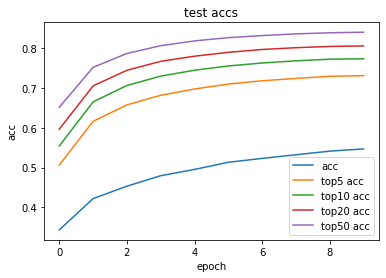

In [121]:
# record experiment scores
import datetime

with open("last_expr_name.txt", "r+") as last_expr_name:
    try:
        last_expr_name = int(last_expr_name.read())+1
    except:
        last_expr_name = 0
with open("last_expr_name.txt", "w") as expr_names:
    expr_names.write(str(last_expr_name))

experiment_name = f"expr{last_expr_name}_{datetime.date.today()}"

import os
expr_dir = Path("records")/experiment_name
(expr_dir/"model").mkdir(parents=True, exist_ok=True)

print("saving at", str(expr_dir/"model/model"))
# model.save_weights(str(expr_dir/"model/model"))

topn_labels = ["acc", "top5 acc", "top10 acc", "top20 acc", "top50 acc"]
train_accs = [train_accs_rec[label] for label in topn_labels]
test_accs = [test_accs_rec[label] for label in topn_labels]
for label, train_acc, test_acc in zip(topn_labels, train_accs, test_accs):
    kwargs = {
        "title": f"test {label}",
        "xlabel": "epoch",
        "ylabel": label
    }
    save_accs(expr_dir/"scores", [test_acc], kwargs)
    
    kwargs = {
        "title": f"train {label}",
        "xlabel": "epoch",
        "ylabel": label
    }
    save_accs(expr_dir/"scores", [train_acc], kwargs)
    
kwargs = {
    "title": f"test accs",
    "xlabel": "epoch",
    "ylabel": "acc",
    "legend": topn_labels
}
save_accs(expr_dir/"scores", test_accs, kwargs)


with open(expr_dir/"scores"/"raw_scores.pickle", "wb+") as raw_scores_handle:
    scores = {}
    for label in topn_labels:
        scores[f"train {label}"] = train_accs_rec[label]
        scores[f"test {label}"] = test_accs_rec[label]
    pickle.dump(scores, raw_scores_handle)
    
plt.hist(model.)

In [123]:
print(model.dense3.weights[0].shape)
print(model.dense3.weights[1].shape)

(512, 128)
(128,)


In [16]:
# with tf.Session() as sess:
#     y_true = tf.placeholder(dtype=tf.float64, shape=[None, 1])

#     learning_rate=.001
#     epochs=60
#     ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
#     train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(ce_loss_term)

#     sess.run(tf.global_variables_initializer())

#     for epoch in tqdm(range(epochs), leave=False):
#         print("epoch", epoch)
#         print("training")
#         for b_Xs, b_ys in batchify(train_Xs, train_ys, batch_size=746661):
#             session_idxs, item_idxs = b_Xs.T
#             feed_dict = {session_slice_idxs: session_idxs, 
#                         item_slice_idxs: item_idxs, 
#                         y_true: b_ys}
#             outs = (train_step, ce_loss_term, pred_y)
#             _, loss_val, pred_y_val = sess.run(outs, feed_dict=feed_dict)
#             print("pred_ys", pred_y_val, "true_ys", b_ys[:5])



In [ ]:
print(x_train[:10])

# model.predict(np.array([[42449, 42446, 42436, 42335, 42461, 42449, 42436, 42335]], dtype=np.uint32))


# plt.hist(np.sum(interaction_matrix, axis=1), log=True, bins=300)
# plt.xlabel("item views per session")
# plt.ylabel("count")
# plt.show()

In [28]:
print(fake_x_train[0])
# plt.hist([v for _, v  in dict(Counter(df["itemId"])).items()], log=True, bins=1000)
# plt.xlabel("number of sessions that viewed item x")
# plt.ylabel("count")
# plt.show()

[25417 49679 37293 15398   981 14834 33095   471]


In [33]:
model.predict(np.array([[5485, 1403, 30082, 47289, 10502, 14578, 12312, 1604]], dtype=np.uint32))


# users = df["userId"].to_numpy()
# print(sum(np.isnan(users))/len(users))
# # most interactions don't have userids

array([[0.945, 0.0552, 4.84e-11, 4.52e-11, 4.46e-11, 3.99e-11, 4.21e-11, 5.11e-11, 4.6e-11, 4.9e-11, 4.98e-11, 4.27e-11, 6.05e-11, 4.97e-11, 4.68e-11, 5.24e-11, 4.64e-11, 4.18e-11, 4.14e-11, 4e-11, 4.91e-11, 5.36e-11, 4.8e-11, 4.4e-11, 5.25e-11, 4.7e-11, 4.75e-11, 4.55e-11, 3.98e-11, 5.61e-11, ..., 3.42e-11, 4.66e-11, 4.48e-11, 3.92e-11, 4.89e-11, 5.2e-11, 4.37e-11, 4.48e-11, 4.71e-11, 4.17e-11, 4.53e-11, 4.57e-11, 4.89e-11, 4.94e-11, 4.65e-11, 4.21e-11, 4.72e-11, 5.01e-11, 4.71e-11, 4.52e-11, 4.53e-11, 4.75e-11, 4.53e-11, 5.01e-11, 4.76e-11, 5.23e-11, 4.59e-11, 4.56e-11, 4.12e-11, 3.71e-11]], dtype=float32)

In [ ]:
# print(len(set(df["sessionId"].to_numpy())))
# print(max(df["sessionId"].to_numpy()))
# # half of all sessions don't have any info at all


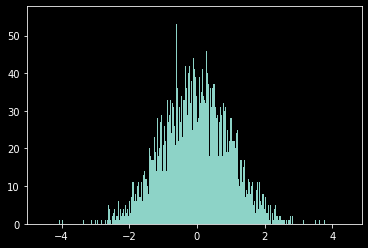

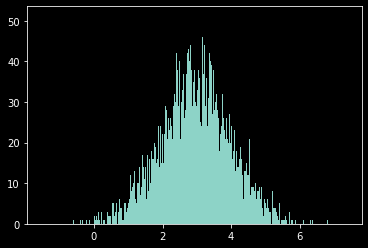

(array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([-3.41, -3.41, -3.41, -3.41, -3.41, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.39, -3.39, -3.39, -3.39, -3.39, -3.39, -3.39, -3.39, -3.38, -3.38, -3.38, -3.38, -3.38, -3.38, -3.38, -3.38, -3.37, ..., 9.24, 9.24, 9.24, 9.24, 9.24, 9.24, 9.24, 9.25, 9.25, 9.25, 9.25, 9.25, 9.25, 9.25, 9.25, 9.26, 9.26, 9.26, 9.26, 9.26, 9.26, 9.26, 9.26, 9.27, 9.27, 9.27, 9.27, 9.27, 9.27, 9.27]),
 <a list of 10000 Patch objects>)

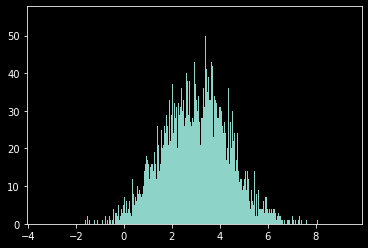

In [14]:
# model
# NUM_SESSIONS, NUM_ITEMS = len(sess_id_to_idx), len(item_id_to_idx)
# embedding_dim = 500

# session_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([NUM_SESSIONS, embedding_dim]))
# item_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([embedding_dim, NUM_ITEMS]))

# session_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
# item_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing

# session_embedding_columns = tf.reshape(tf.gather_nd(session_embeddings, session_slice_idxs), [-1, embedding_dim])
# item_embedding_rows = tf.reshape(tf.gather_nd(item_embeddings, session_slice_idxs), [-1, embedding_dim])

# matrix_factorization_layer = session_embedding_columns * item_embedding_rows

# pred_y = tf.nn.sigmoid(matrix_factorization_layer)